# Исследования факторов влияющих на выручку сервиса аренды самокатов

В данной работе проведено исследование данных по пользователям, из нескольких городов, популярного сервиса аренды самокатов. Чтобы совершать покупки, поьзователи используют мобильное приложение. 

Данные для исследование следующие: 
- **`users_go.csv`**: содержит информацию о пользователях, а именно 
    - **`user_id`** уникальный идентификатор пользователя 
    - **`name`** имя пользователя
    - **`age`** возраст пользователя
    - **`city`** город
    - **`subscription_type`** тип подписки (free - без подписки, ultra - с подпиской)
- **`rides_go.csv`**: содержит информацию о поездках, которые совершили пользователи
    - **`user_id`** уникальный идентификатор пользователя
    - **`distance`** растояние, которое преодолел пользователь в текущей сессии в метрах
    - **`duration`** продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
    - **`date`** дата совершения поездки
- **`subscriptions_go.csv`**: содержит информацию о типах подписки
    - **`subscription_type`**	тип подписки
    - **`minute_price`**	стоимость одной минуты поездки по данной подписке
    - **`start_ride_price`**	стоимость начала поездки
    - **`subscription_fee`**	стоимость ежемесячного платежа

Мы хотим проделать следущее:
- Выполнить исследовательский анализ данных
- Посчитать помесячную выручку для каждого пользователя
- Проверить тратят ли пользователи с подпиской больше времени на поездки, чем пользователи без подписки
- Проверить не превышает ли среднее растояние, котрое проезжают пользователи оптимальные для самоката 3130 метров
- Проверить - выше помесячная выручка от пользователей с подпиской или нет
- Вычислить минимальное число промокодов, которые нужно раздать, что бы увеличить число пользователей с подпиской минимум на **100**, с верояностью не выполнить план в **5%**.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

#### Шаг 1. Загрузка данных

##### Пользователи

In [2]:
users = pd.read_csv('users_go.csv')

In [3]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


В usres **1565** значений. Пропусков нет. Названия столбцов хорошие. Типы данных соотвесуют.

##### Поездки

In [5]:
rides = pd.read_csv('rides_go.csv')

In [6]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [7]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Всего **18068** строк. Пропусков нет. Все типы, кроме `date` - подходящие.

##### Подписки

In [8]:
subns = pd.read_csv('subscriptions_go.csv')

In [9]:
subns.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [10]:
subns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


Всего **2** строки. Информация о двух типах подписки. Без пропусков и подхоядщими типами данных.

#### Шаг 2. Предобработка данных

##### Приведите столбец date к типу даты pandas

In [11]:
rides.date = pd.to_datetime(rides.date, format='%Y-%m-%d')
pd.DataFrame(rides.date).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 141.3 KB


##### Создайте новый столбец с номером месяца на основе столбца date

In [12]:
rides['month'] = pd.DatetimeIndex(rides.date).month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [13]:
print('Начало периода:', rides.date.min())
print('Конец периода:', rides.date.max())
rides.date.max() - rides.date.min()

Начало периода: 2021-01-01 00:00:00
Конец периода: 2021-12-30 00:00:00


Timedelta('363 days 00:00:00')

##### Проверьте наличие пропущенных значений и дубликатов в датафреймах. Обработайте их, если такие значения присутствуют.

###### Пользователи

In [14]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [15]:
users.duplicated().sum()

31

In [16]:
users = users.drop_duplicates().reset_index(drop=True)
users.duplicated().sum()

0

Обнаружено и  устранено 31 дубликатов.

###### Поездки

In [17]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [18]:
rides.duplicated().sum()

0

Пропусков и дубликатов нет.

###### Подписки

In [19]:
subns

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Ни пропусков, ни дубликатов! 

###### Дополнительная проверка

In [20]:
users.user_id.value_counts().describe()

count    1534.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: count, dtype: float64

Все пользователи имеют уникальный `user_id`

In [21]:
len(rides.user_id.unique())

1534

Общее число уникальных пользователей в обоих таблицах сходится. 

In [22]:
len(set(users.user_id.unique()) & set(rides.user_id.unique()))

1534

Таблицы полнстью соответствуют друг-другу. 

В результате предобработки выполнено следующее:
- данные столбеца `date` привеведены к типу *datetime*
- в `rides` добавлен дополнительный столбец с номером месяца `month`
- посчитано, что данные в `rides` представлены за период в 363 дня
- в `users` обнаружен и устранен 31 дубликат
- проверено, что все пользователи имеют уникальный `user_id`
- преверено, что общее число уникальных пользователей в обоих таблицах (`users` и `rides`) сходится

#### Шаг 3. Исследовательский анализ данных

##### Частота встречаемости городов

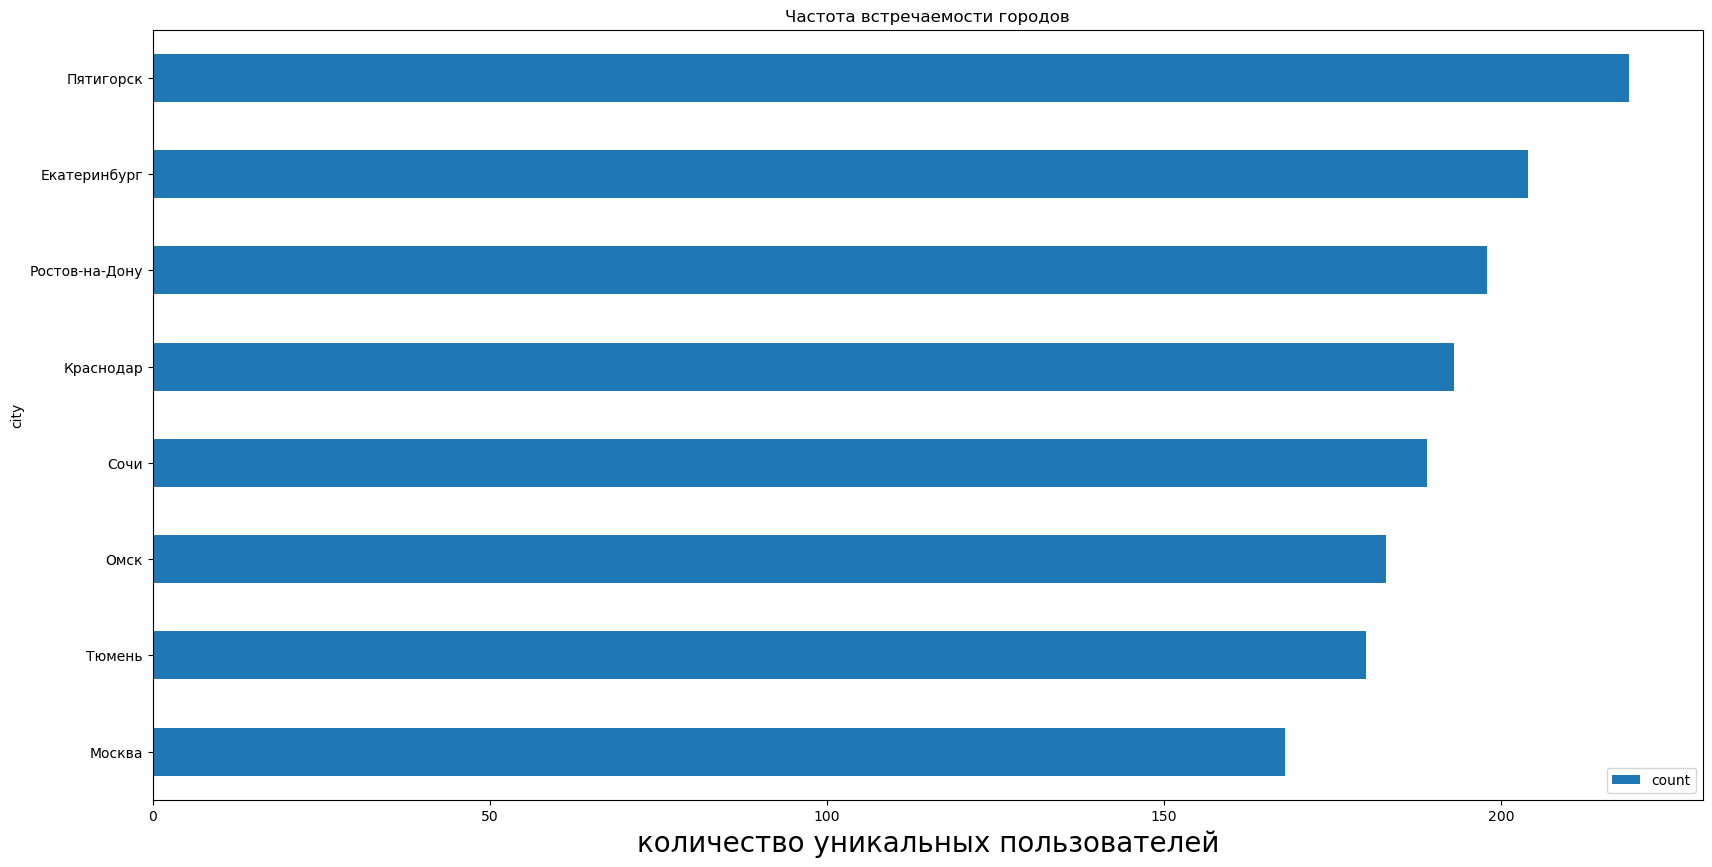

In [23]:
(users.city
           .value_counts()
           .sort_values(ascending=True)
           .to_frame()
           .plot(kind='barh', figsize=(20, 10), title='Частота встречаемости городов')
           .set_xlabel('количество уникальных пользователей', fontsize=20)
);

In [24]:
(users.city
           .value_counts()
           .sort_values(ascending=False)
)

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

Всего приложение используют в 8 городах. Больше всего клиентов в Пятигорске, меньше всего в Москве.

##### Cоотношение пользователей с подпиской и без подписки

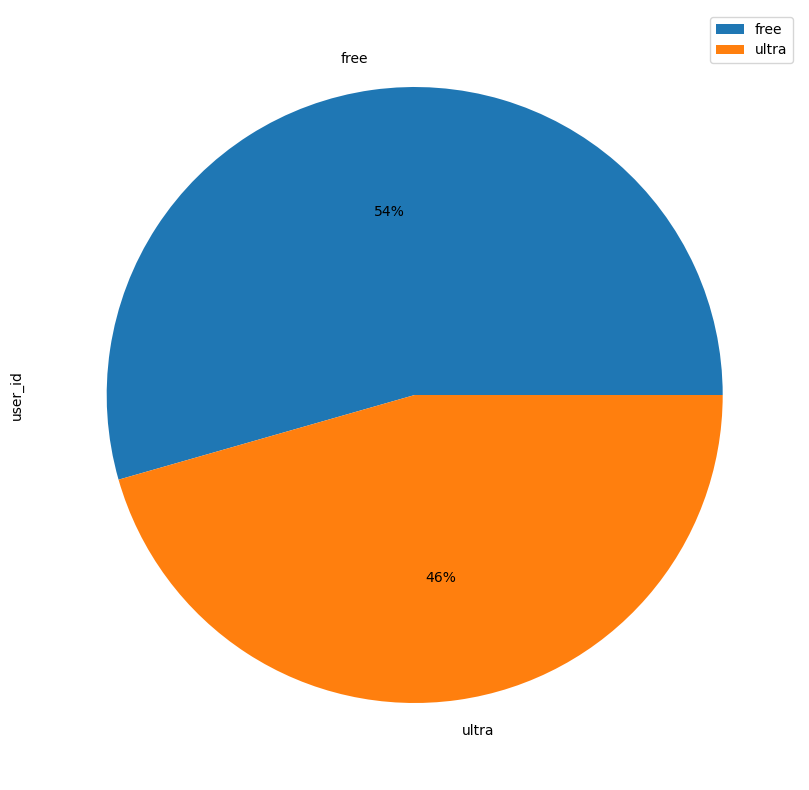

In [25]:
(users.pivot_table(index='subscription_type', values='user_id', aggfunc='count')
      .plot.pie(y='user_id', figsize=(10, 10), autopct='%1.0f%%')
);

**54%** пользователей сервиса без подписки (**free**) и **46%** - с подпиской (**ultra**)

##### Возраст пользователей

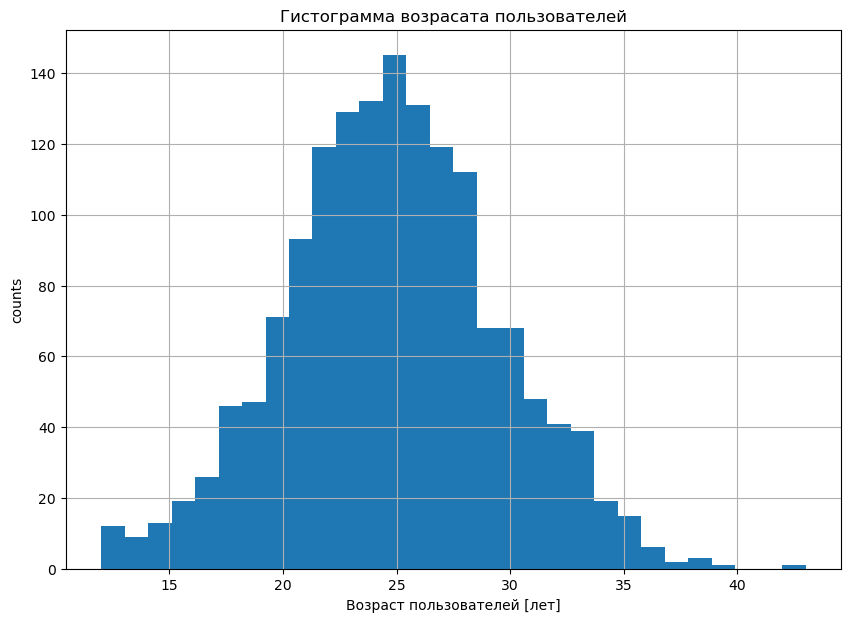

In [26]:
now_plt = users.age.hist(bins=30, figsize=(10, 7))
now_plt.set_title('Гистограмма возрасата пользователей')
now_plt.set_xlabel('Возраст пользователей [лет]')
now_plt.set_ylabel('counts');

In [27]:
users.age.describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Распределение возраста пользователей - близко к нормальному, со средним 25 и стандартным отклонением 5. Минимальный возрас пользователя 12 лет, максимальный 43. 

In [28]:
users[users.age != 43].age.describe()

count    1533.000000
mean       24.891716
std         4.550416
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        39.000000
Name: age, dtype: float64

43 лежит за пределами 3std (40 лет), но уже второй максимум входит в пределы ${+}{-}$ 3std. Один выброс не повлияет на выводы по этим данным.

##### Расстояние, которое пользователь преодолел за одну поездку

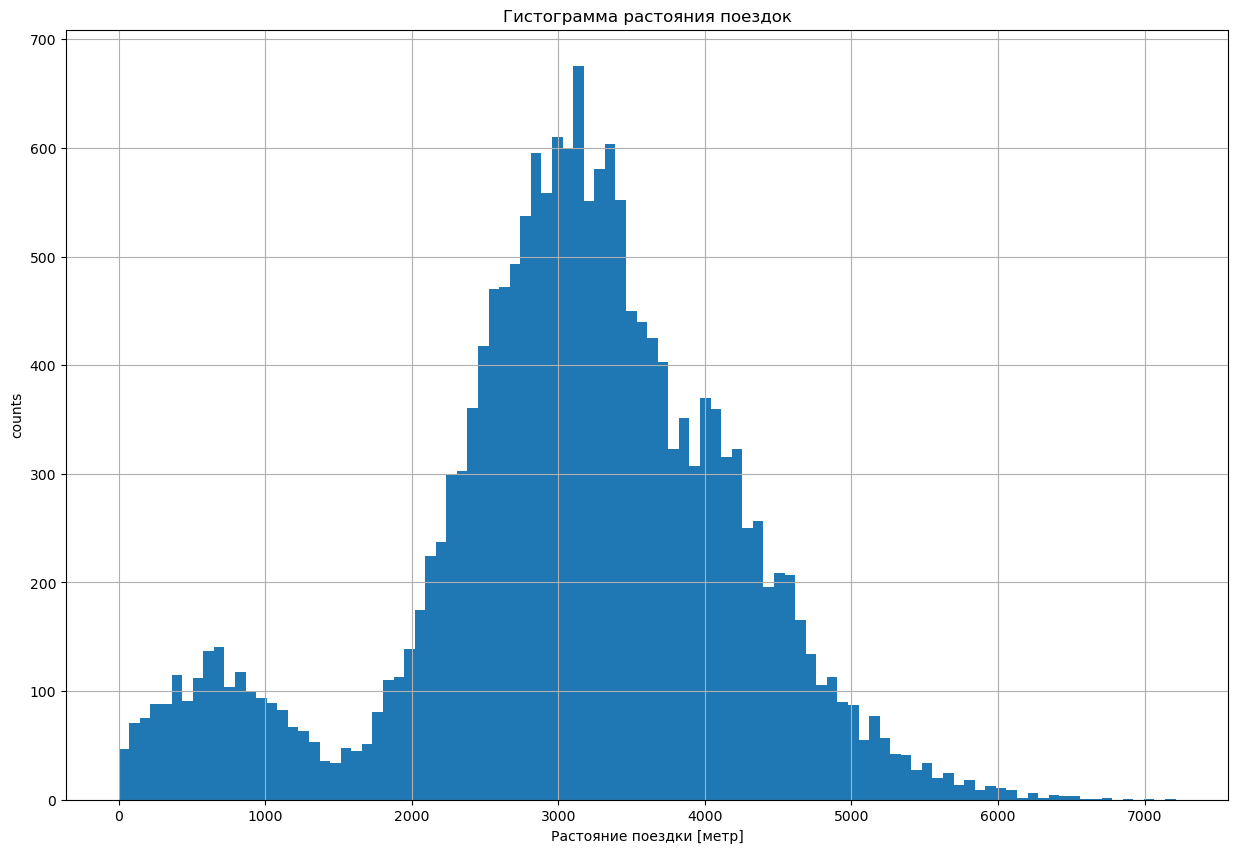

In [29]:
now_plt = rides.distance.hist(bins=100, figsize=(15, 10))
now_plt.set_title('Гистограмма растояния поездок')
now_plt.set_xlabel('Растояние поездки [метр]')
now_plt.set_ylabel('counts');

На графике 2 пика, в области около 600 и 3000 метров, а так немного заметен кандидат-пик в области 4000 метров. Похоже на то, что на графике несколько разных распределения в одном.
Поробуем их разделить. 

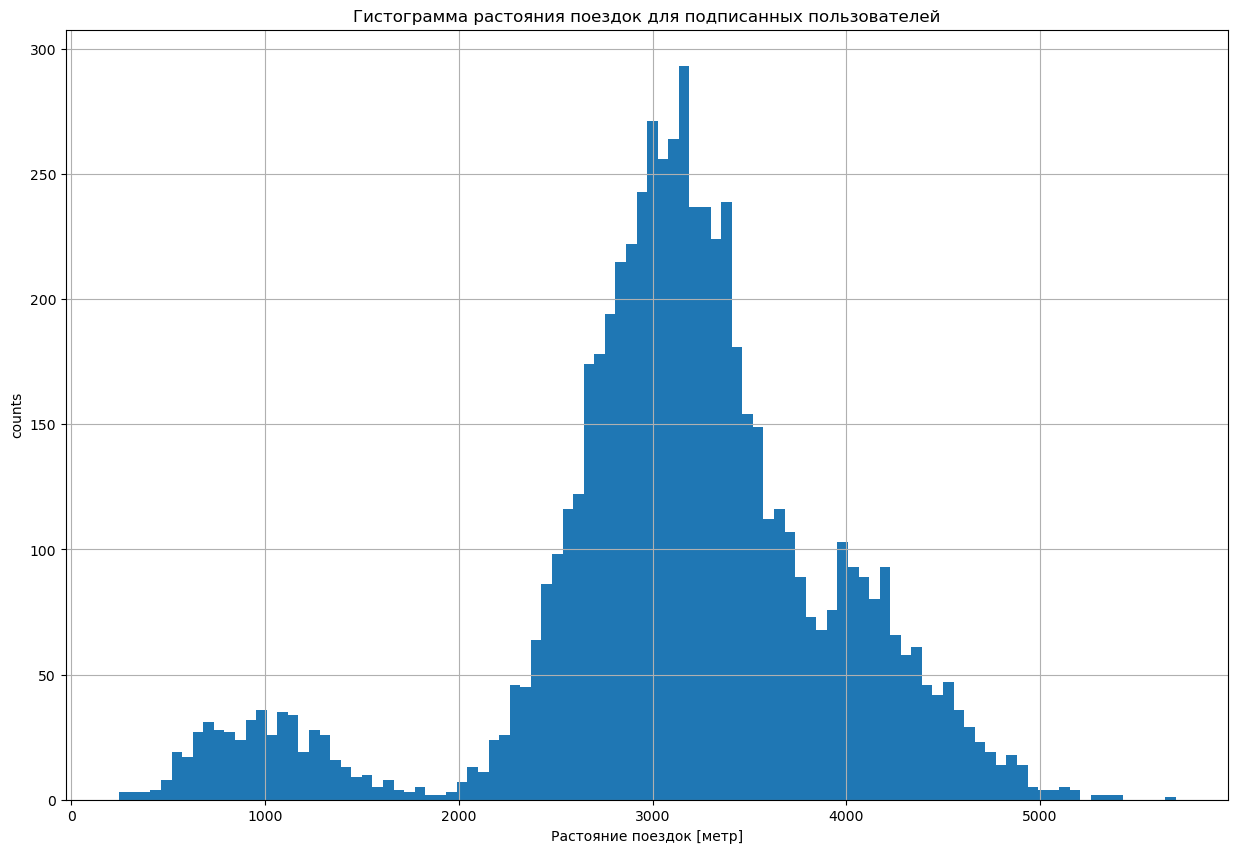

In [30]:
rides_and_usres = rides.merge(users, on='user_id')
now_plt = rides_and_usres[rides_and_usres.subscription_type == 'ultra'].distance.hist(bins=100, figsize=(15, 10))
now_plt.set_title('Гистограмма растояния поездок для подписанных пользователей')
now_plt.set_xlabel('Растояние поездок [метр]')
now_plt.set_ylabel('counts');

У пользователей с подпиской 3 пика выражены более явно.

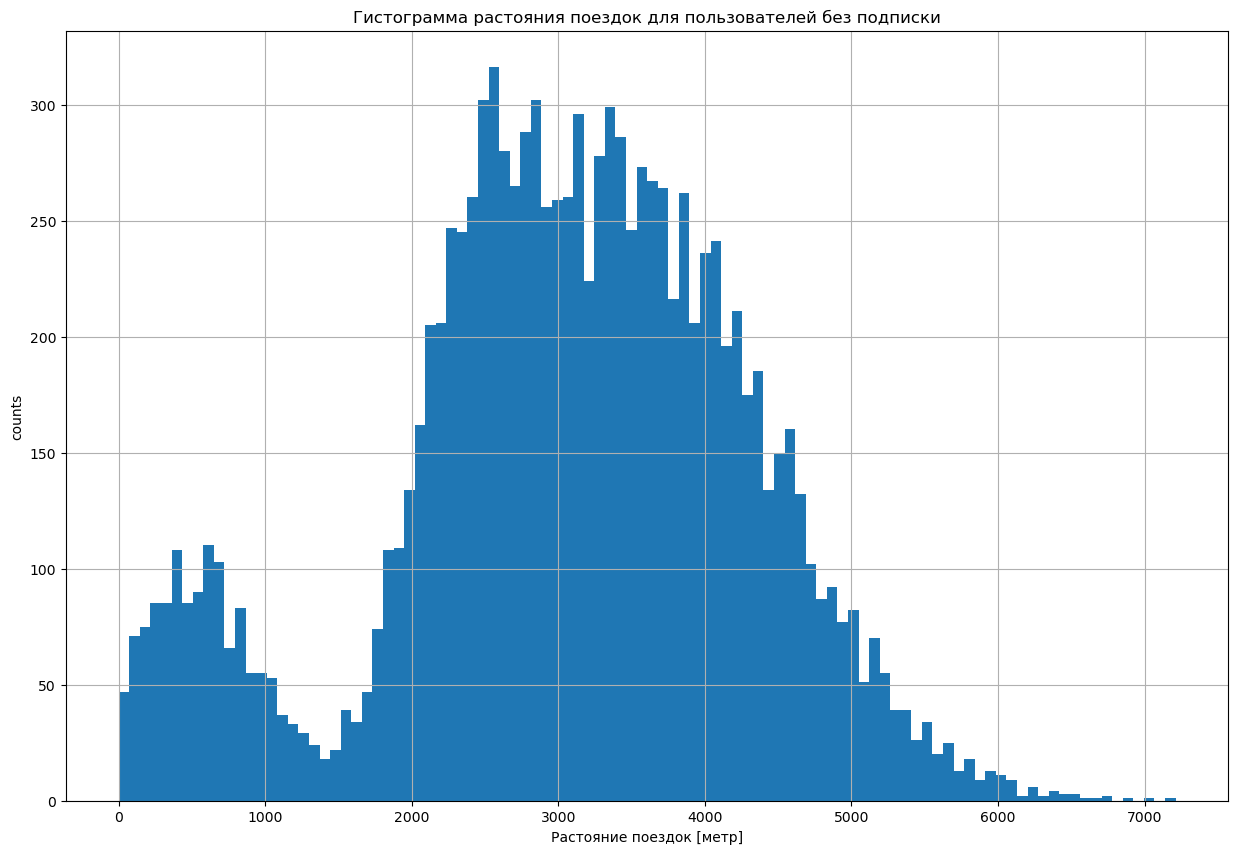

In [31]:
now_plt = rides_and_usres[rides_and_usres.subscription_type == 'free'].distance.hist(bins=100, figsize=(15, 10))
now_plt.set_title('Гистограмма растояния поездок для пользователей без подписки')
now_plt.set_xlabel('Растояние поездок [метр]')
now_plt.set_ylabel('counts');

У пользователей без подписки пиков всего 2.

Вывод.
Расстояние, которое преодолевают пользователи представляет из себя смешанное распределение, предположительно, с 3-мя состовляющими. На данном шаге, природа подраспределений не ясна, но предположительно это может быть сезонность. 

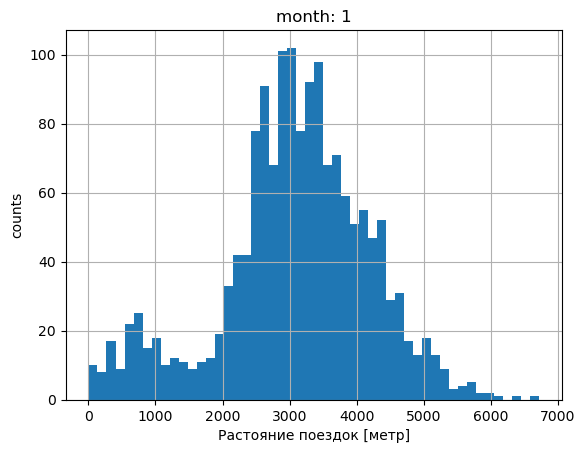

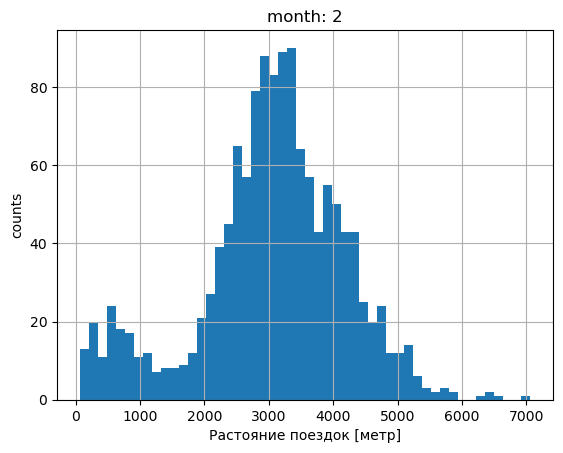

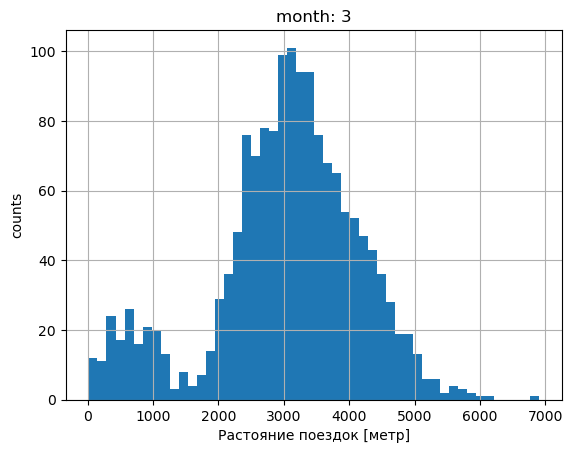

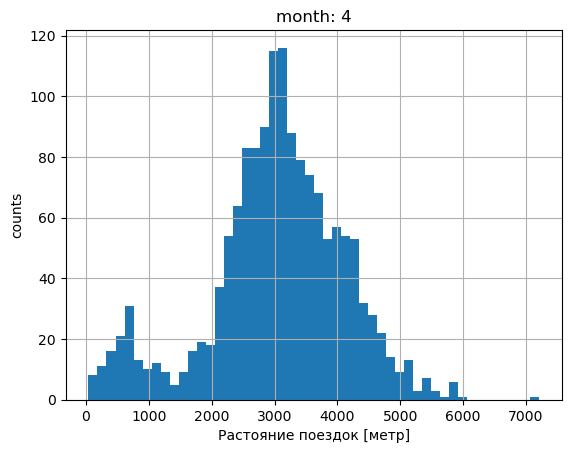

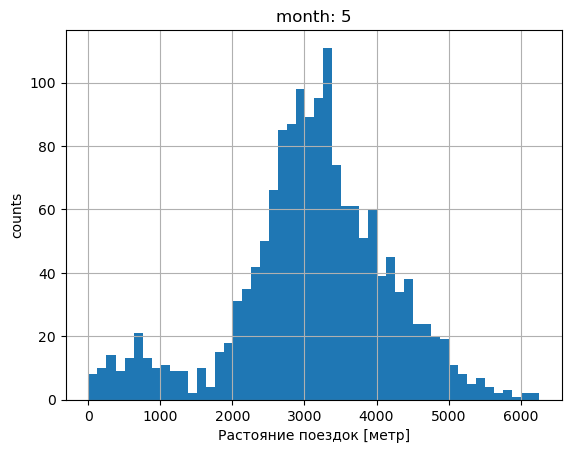

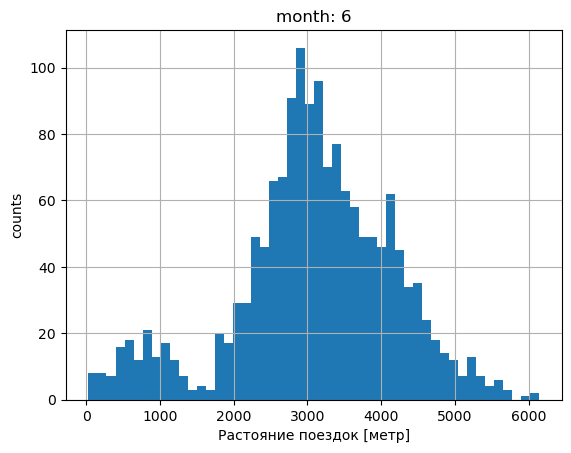

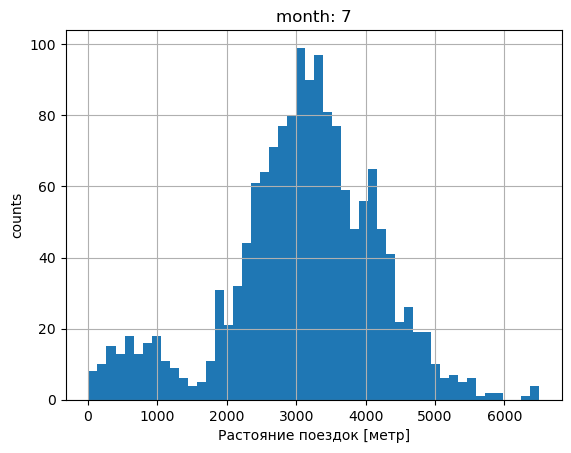

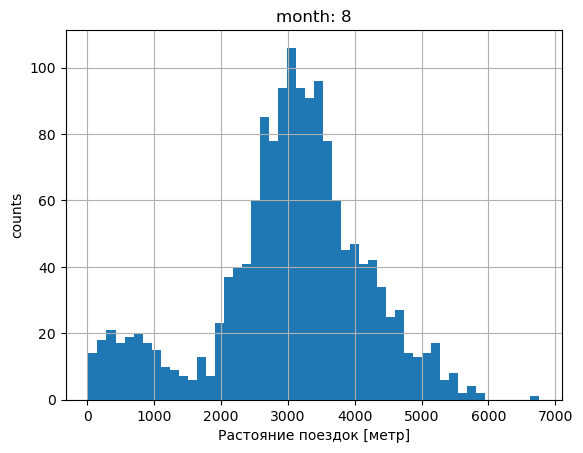

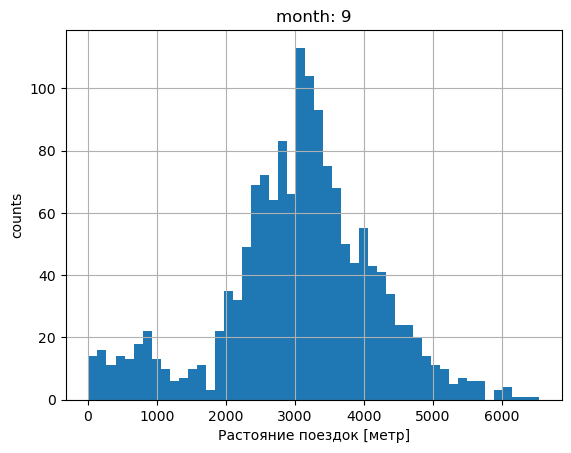

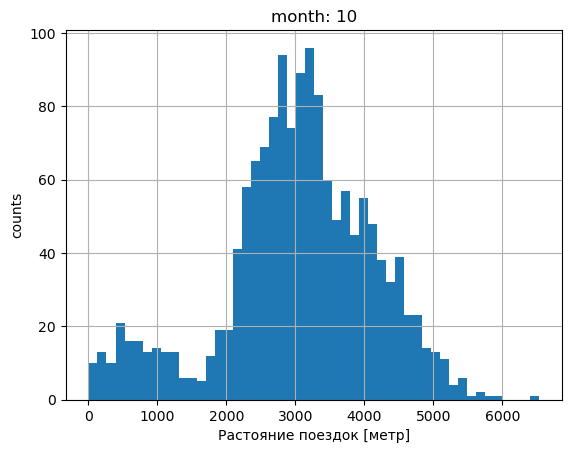

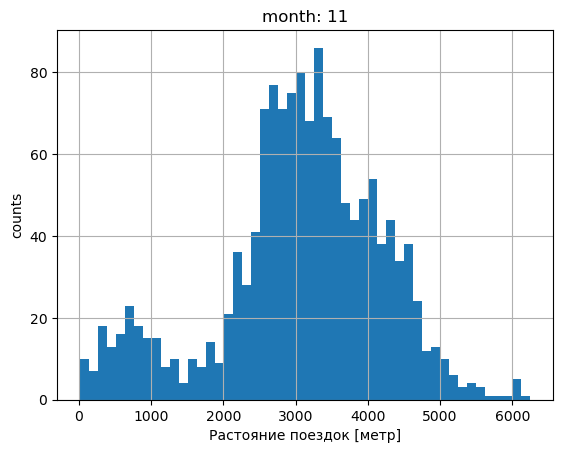

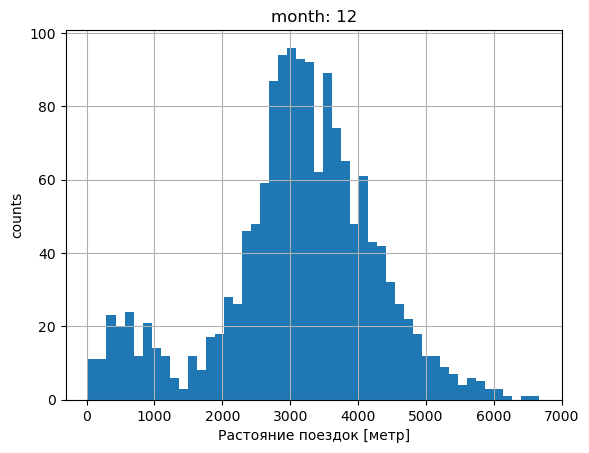

In [32]:
for month in range(1, 12 + 1):
    now_plt = rides_and_usres[rides_and_usres.month == month].distance.hist(bins=50)
    now_plt.set_title(f'month: {month}')
    now_plt.set_xlabel('Растояние поездок [метр]')
    now_plt.set_ylabel('counts')
    plt.show()

В каждом месяце наблюдаются все те же смешанные распределения. Вывод на этом шаге: причина - не сезонность.

Возможно это обусловлено временем суток.. но данных по времени суток у нас нет. Не сможм проверить на этом этапе. Остановлюсь на этом. Вопрос остается открытым.Возможно это просто короткие поездки до ближайшей остановки или станции метро.

##### Продолжительность поездок

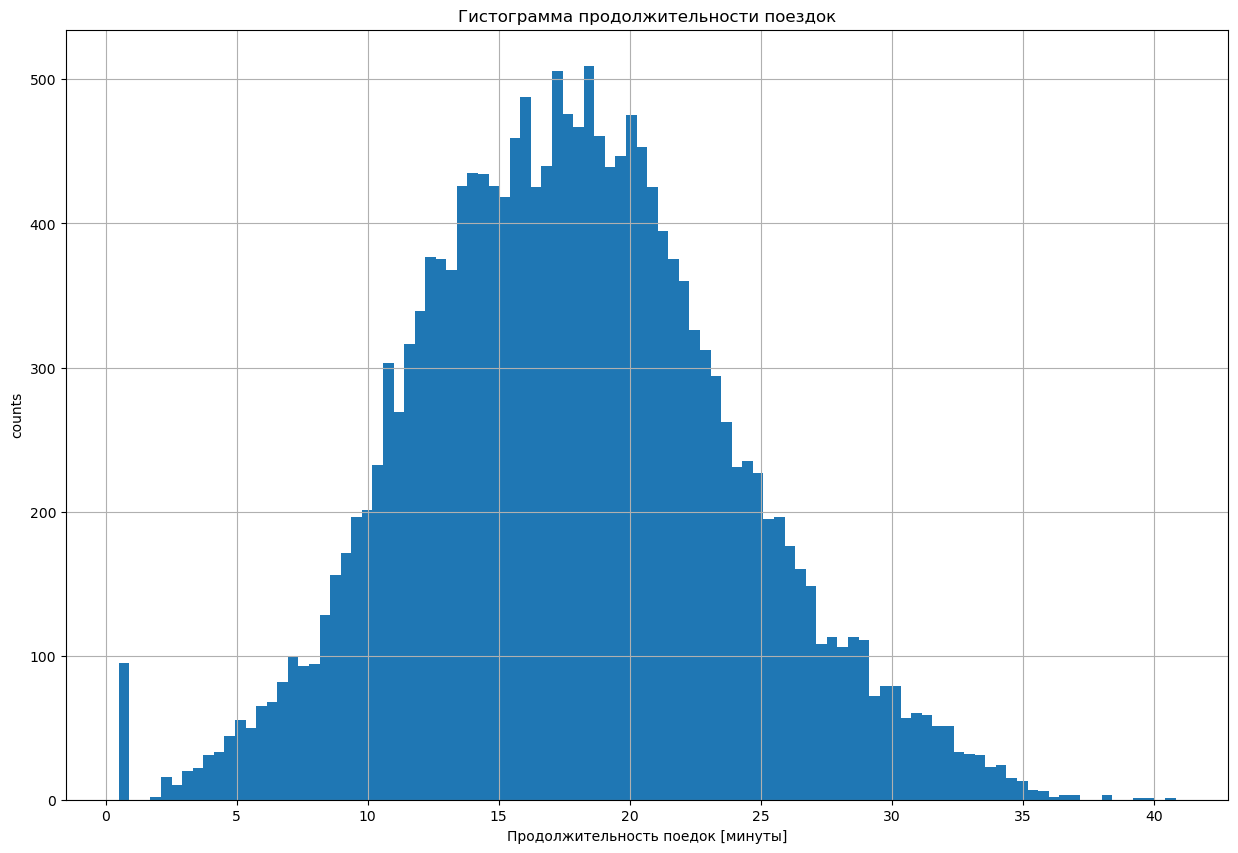

In [33]:
now_plt = rides.duration.hist(bins=100, figsize=(15, 10))
now_plt.set_title('Гистограмма продолжительности поездок')
now_plt.set_xlabel('Продолжительность поедок [минуты]')
now_plt.set_ylabel('counts');

In [34]:
rides.duration.describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Продолжительность поездок распределена очень близко к нормальному закону, со средним около 18 и std 6 минут. Есть аномальный пик около 0.

In [35]:
rides[rides.duration == 0.5]

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


In [36]:
rides[rides.duration == 0.5].distance.mean()

5113.176548536017

In [37]:
rides[rides.duration != 0.5].distance.mean() / rides[rides.duration != 0.5].duration.mean()

170.97573174084337

In [38]:
(rides[rides.duration == 0.5].duration.count() / rides.duration.count()) * 100

0.5257914545052026

Время 0,5 минуты, а растояние в среднем 5113 метров. Средняя скорость в таком случае примерно 170 метров в секунду, или 613 километров в час. Это очень быстро для самоката. В ячейках ниже я проверил кореляцию растояния и продолжительности, к сожалению полученный результат говорит о том, что нельзя заполнить синтетическими данными обнаруженные аномалии. Т.к. общее число таких аномалии составляет 0,5% от всех данных, то можно просто исключить такие строки.

Text(0.5, 1.0, 'Диаграмма рассеивания для продолжительности и растояния поездок')

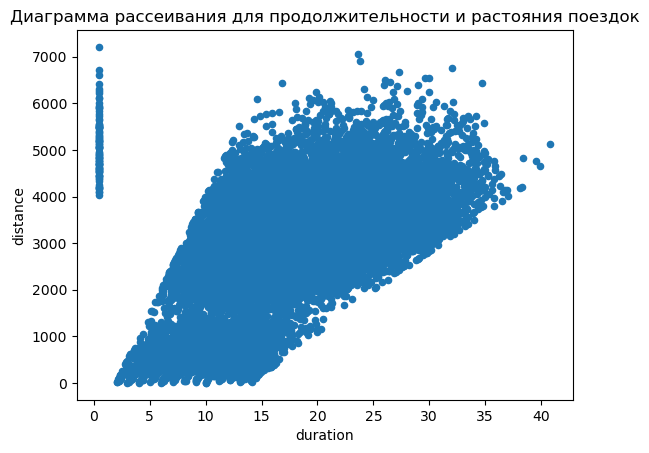

In [39]:
now_plot = rides.plot(kind='scatter', x='duration', y='distance')
now_plot.set_title('Диаграмма рассеивания для продолжительности и растояния поездок')

In [40]:
rides.duration.corr(rides.distance)

0.5367776552505347

In [41]:
len(rides)

18068

In [42]:
rides = rides[rides.duration != 0.5].reset_index(drop=True)

In [43]:
len(rides)

17973

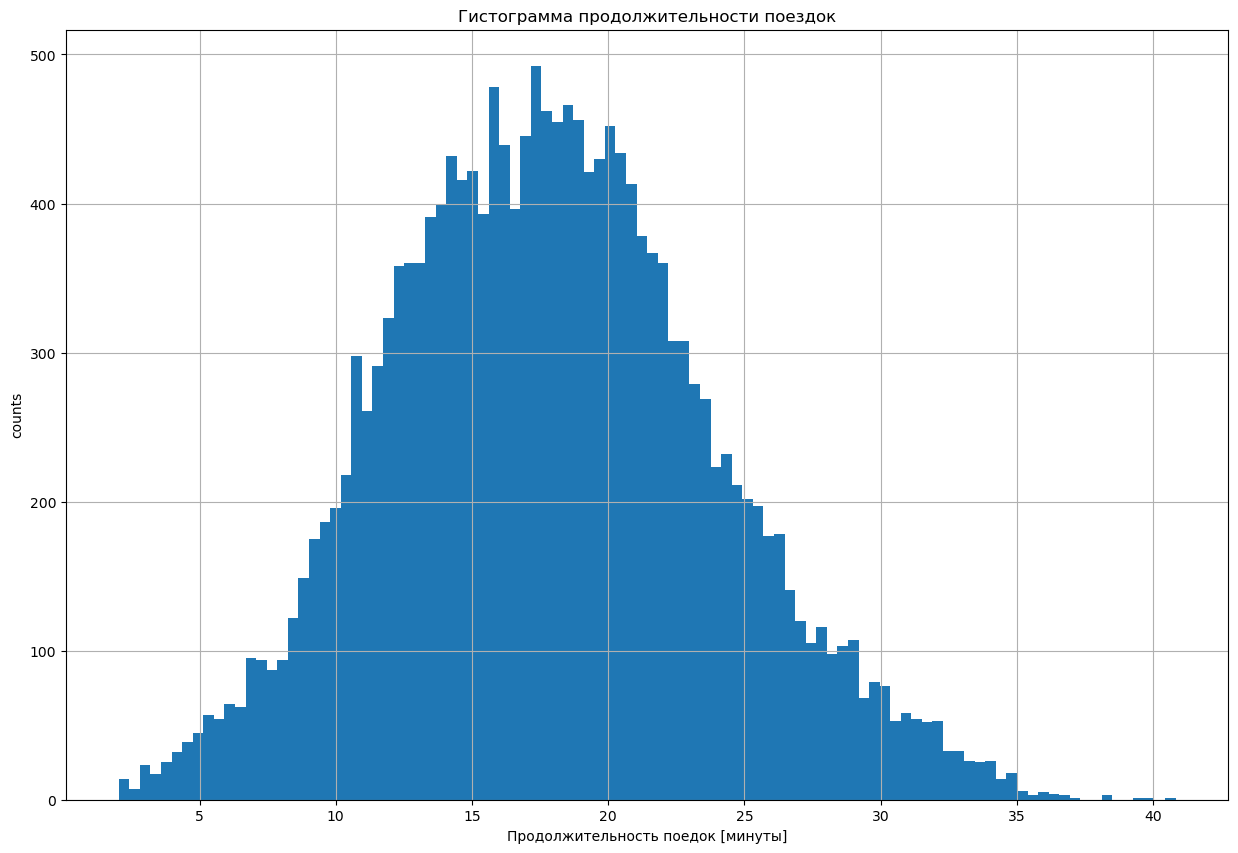

In [44]:
now_plt = rides.duration.hist(bins=100, figsize=(15, 10))
now_plt.set_title('Гистограмма продолжительности поездок')
now_plt.set_xlabel('Продолжительность поедок [минуты]')
now_plt.set_ylabel('counts');

In [45]:
rides.duration.describe()

count    17973.000000
mean        17.896480
std          5.975424
min          2.035632
25%         13.670439
50%         17.714122
75%         21.747016
max         40.823963
Name: duration, dtype: float64

Распределение стало нормальным, со средним в 18 минут и sts 6 минут.

#### Шаг 4. Объединение данных

##### Объедините данные о пользователях, поездках и подписках в один датафрейм

In [46]:
data = users.merge(rides, on='user_id')

In [47]:
data = data.merge(subns, on='subscription_type')

In [48]:
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [49]:
data.tail()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
17968,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
17969,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
17970,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
17971,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0
17972,1534,Альберт,25,Краснодар,free,2371.711192,15.893917,2021-12-29,12,8,50,0


Тут стоит проверить количество строк полученной таблицы и сравнить ее с количеством строк таблиц до объединения, чтобы убедиться что мы ничего не потеряли.

In [50]:
print('Количество строк в users: ', len(users))
print('Количество строк в rides:', len(rides))
print('Количество строк в объединении таблиц:', len(data))

Количество строк в users:  1534
Количество строк в rides: 17973
Количество строк в объединении таблиц: 17973


Число строк в объединенной таблице сопало с числом строк в rides. Мы объединяли по user_id, выше мы выяснили, что по user_id таблицы полностью соотвесвуют друг другу т.е. в users нет  таких user_id, которых нет rides и наоборот, в rides нет  таких user_id, которых нет в users. Следовательно, мы делаем вывод, что мы ничего не потеряли.

##### Создайте ещё два датафрейма из датафрейма

###### С данными о пользователях без подписки

In [51]:
data_free = data[data.subscription_type == 'free']
data_free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


######  С данными о пользователях с подпиской

In [52]:
data_ultra = data[data.subscription_type == 'ultra']
data_ultra.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


##### Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий

###### free

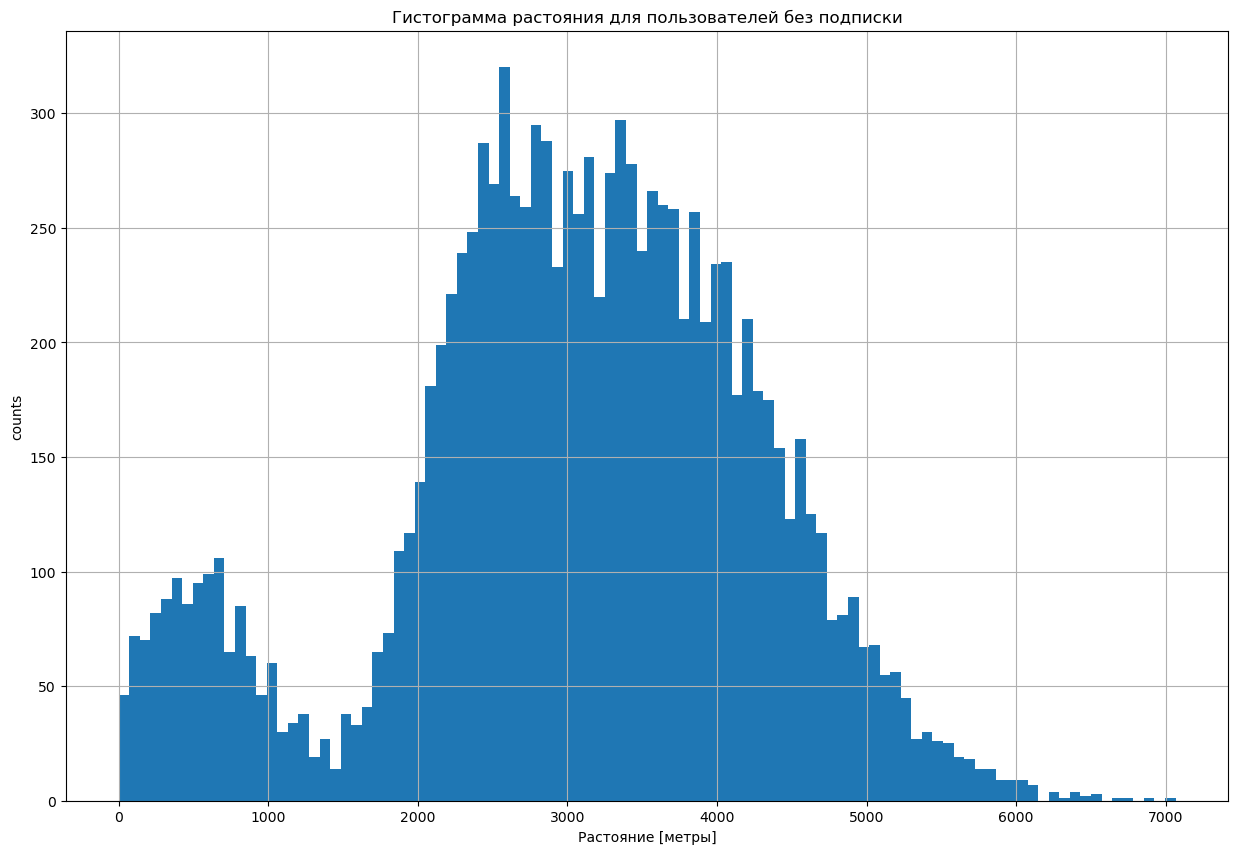

In [53]:
now_plt = data_free.distance.hist(bins=100, figsize=(15, 10))
now_plt.set_title('Гистограмма растояния для пользователей без подписки')
now_plt.set_xlabel('Растояние [метры]')
now_plt.set_ylabel('counts');

Для пользователей без подписки, наблюдается два пика: в области кокло 500 и около 2200. Два распределения по отдельности похожи на нормальное. 

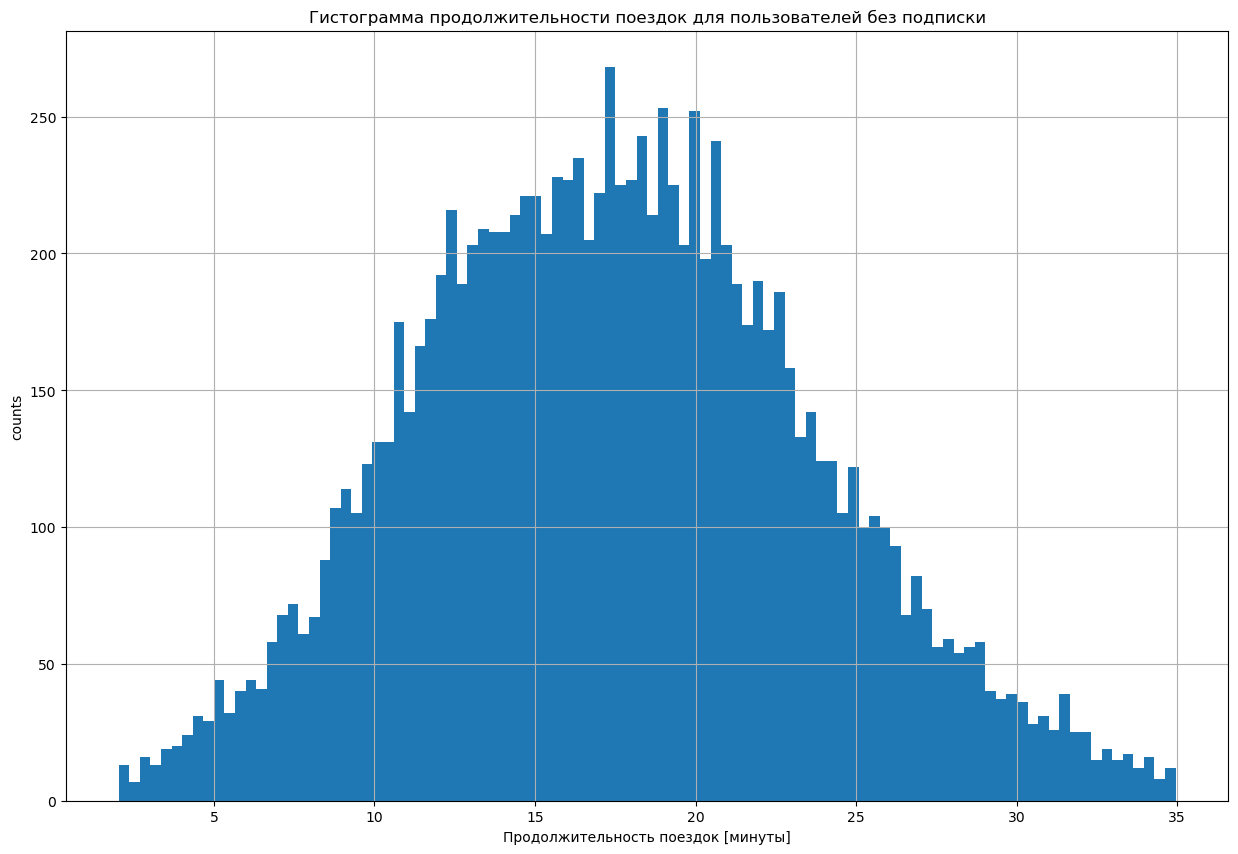

In [54]:
now_plt = data_free.duration.hist(bins=100, figsize=(15, 10))
now_plt.set_title('Гистограмма продолжительности поездок для пользователей без подписки')
now_plt.set_xlabel('Продолжительность поездок [минуты]')
now_plt.set_ylabel('counts');

In [55]:
data_free.duration.describe()

count    11473.000000
mean        17.530771
std          6.162609
min          2.035632
25%         13.085688
50%         17.383807
75%         21.638038
max         34.948498
Name: duration, dtype: float64

Распределение продолжительности поездок для пользователей без подписки, близко к номальному, со средним около 17 и std 6.

###### ultra

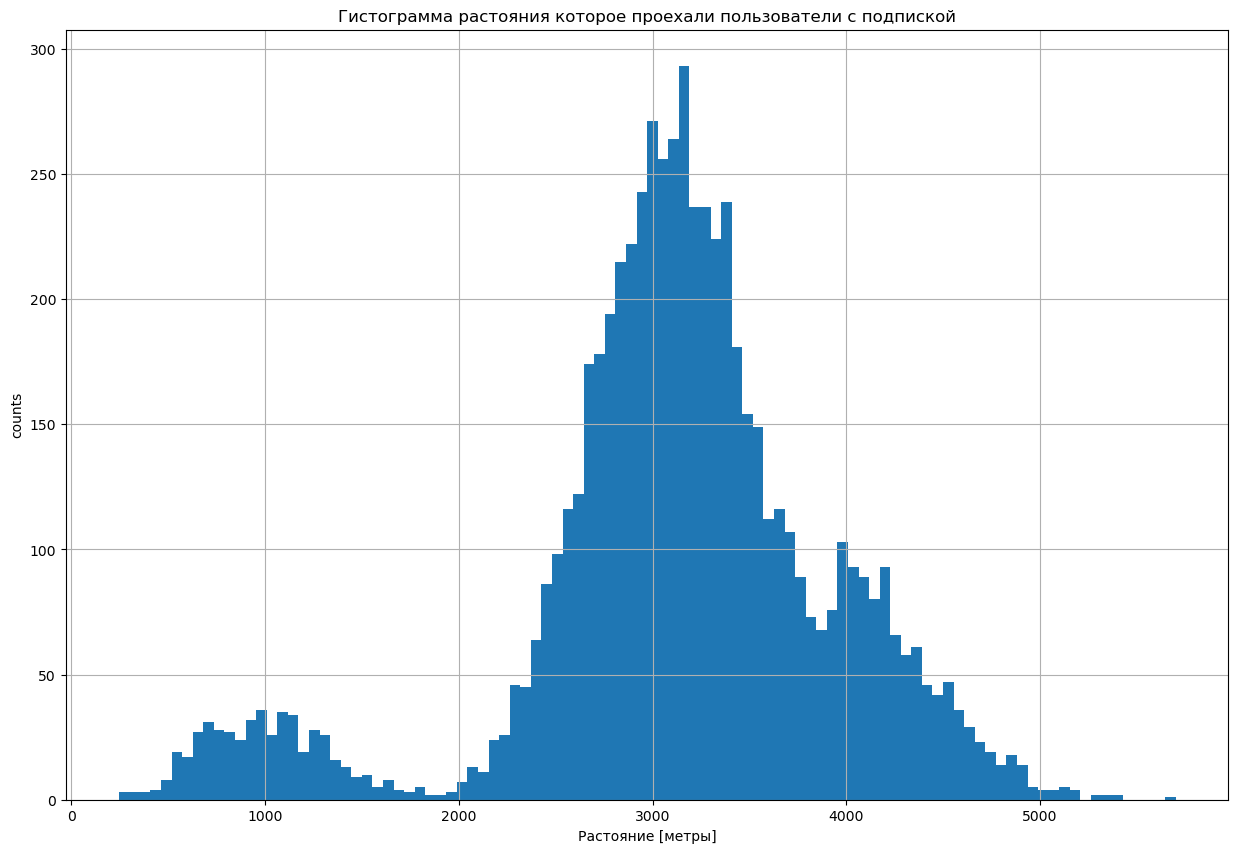

In [56]:
now_plt = data_ultra.distance.hist(bins=100, figsize=(15, 10))
now_plt.set_title('Гистограмма растояния которое проехали пользователи с подпиской')
now_plt.set_xlabel('Растояние [метры]')
now_plt.set_ylabel('counts');

3 пика: 1000, оклоло 3000 и около 4000 метров.

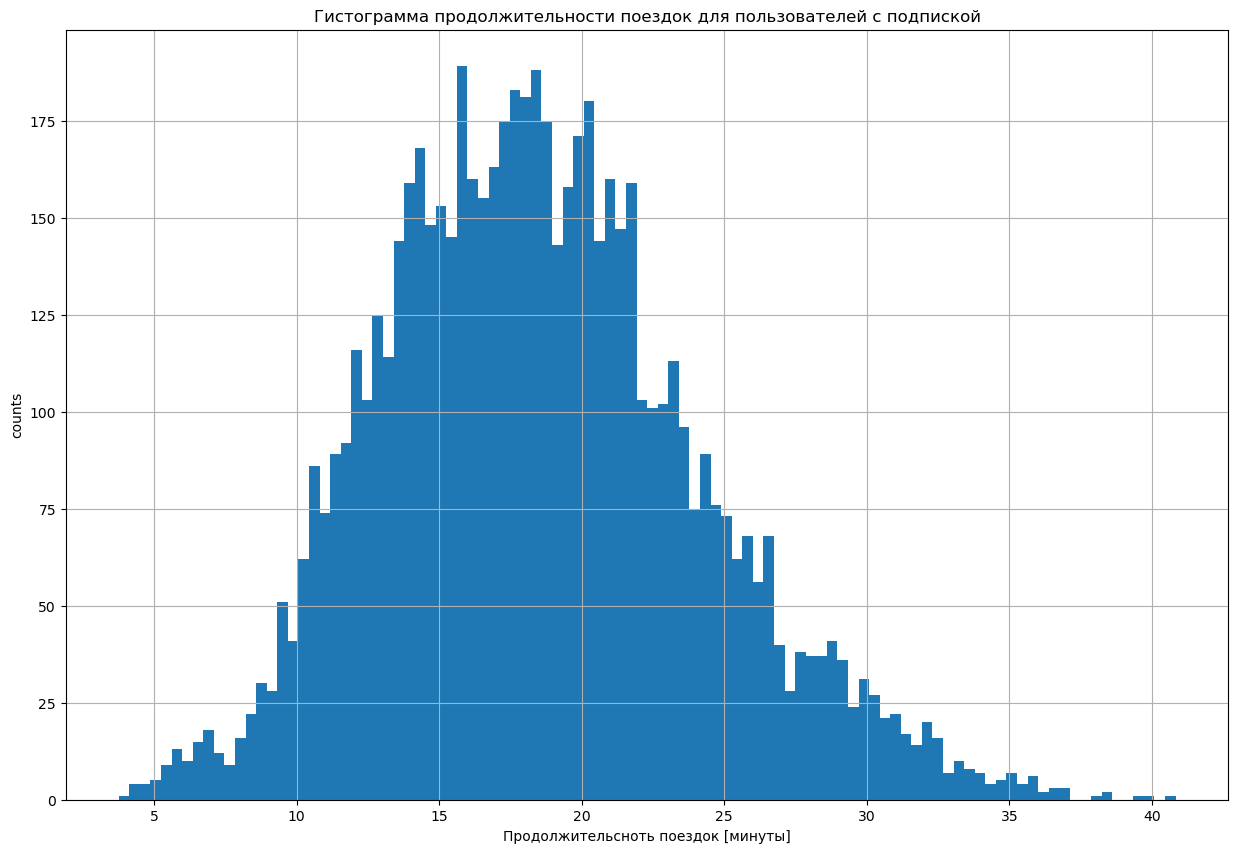

In [57]:
now_plt = data_ultra.duration.hist(bins=100, figsize=(15, 10))
now_plt.set_title('Гистограмма продолжительности поездок для пользователей с подпиской')
now_plt.set_xlabel('Продолжительсноть поездок [минуты]')
now_plt.set_ylabel('counts');

In [58]:
data_ultra.duration.describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

Продолжительность поездок у пользователей с подпиской распределена близко к нормальному закону, со средним 18.5 и std 5.6 минут.

Распределения для обеих групп пользователей можно объединить для наглядности, наложив их друг на друга.

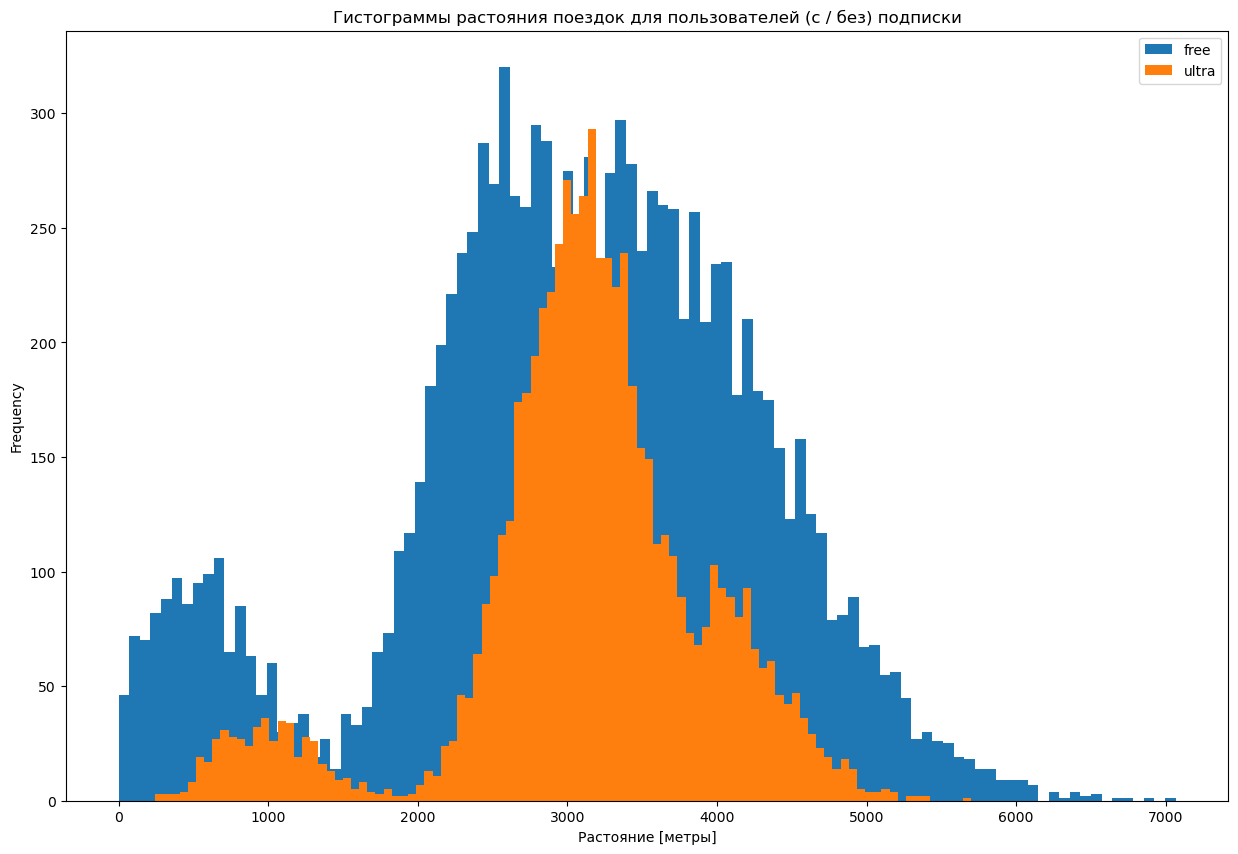

In [59]:
data_free.distance.plot(kind='hist', bins=100, figsize=(15, 10), label='free', legend=True)
now_plt = data_ultra.distance.plot(kind='hist', bins=100, label='ultra', legend=True)
now_plt.set_title('Гистограммы растояния поездок для пользователей (с / без) подписки')
now_plt.set_xlabel('Растояние [метры]');

У обоих распределений два пика. Пики в левой части рисунка не сходятся по среднеиу, пики в правой части - сходятся. Распределение для поьзователей с подпиской уже, это говорит о том что они растояния их поездок находятся ближе друг к другу чем у пользователей без подписки.

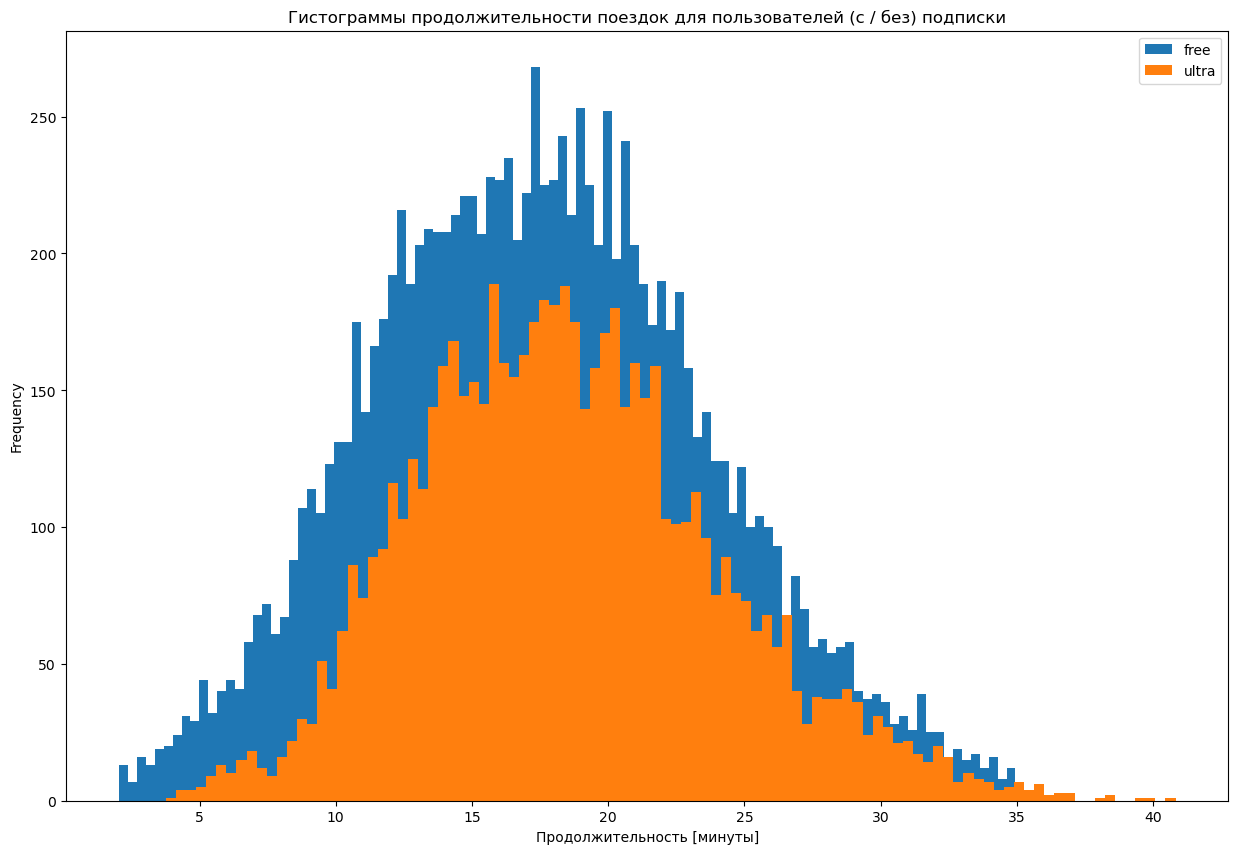

In [60]:
data_free.duration.plot(kind='hist', bins=100, figsize=(15, 10), label='free', legend=True)
now_plt = data_ultra.duration.plot(kind='hist', bins=100, label='ultra', legend=True)
now_plt.set_title('Гистограммы продолжительности поездок для пользователей (с / без) подписки')
now_plt.set_xlabel('Продолжительность [минуты]');

Средние двух рапределении почти сходятся. Разброс значений у пользователей с подпиской, ниже чем для у пользователей без подписки. 

#### Шаг 5. Подсчёт выручки

##### Найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц

###### distance sum

Создадим дополнительную таблицу с инфомацией о суммарном растоянии по каждому месяцу для всех пользователей.

In [61]:
user_sum_distances = data.pivot_table(index='user_id', columns='month', values=['distance'], aggfunc=['sum'])
user_sum_distances.columns = range(1, 12 + 1)
user_sum_distances.head()

,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1,7027.511294,NaN,NaN,754.159807,NaN,NaN,NaN,6723.470560,NaN,5809.911100,7003.499363,6751.629942
2,NaN,NaN,10187.723006,6164.381824,NaN,3255.338202,6780.722964,923.007439,NaN,2824.636598,NaN,3828.248580
3,3061.777147,5421.152016,NaN,2956.651632,9064.026918,NaN,10919.595403,NaN,2891.012822,NaN,NaN,2593.381928
4,NaN,6339.696747,NaN,NaN,NaN,6753.041806,10491.175555,4649.488243,NaN,13260.762274,3343.025291,NaN
5,3914.646990,2561.108241,10633.732186,3373.080412,5823.074031,NaN,3311.974724,2720.817111,NaN,3218.515955,NaN,NaN


In [62]:
user_sum_distances.isna().sum()

1     548
2     656
3     587
4     608
5     557
6     549
7     583
8     587
9     603
10    616
11    627
12    587
dtype: int64

Некоторые пользователи не ездили в конкретные месяци.. отсуда получились пропуски. Логично заполнить их нулями.

In [63]:
user_sum_distances = user_sum_distances.fillna(0)

In [64]:
user_sum_distances.isna().sum()

1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

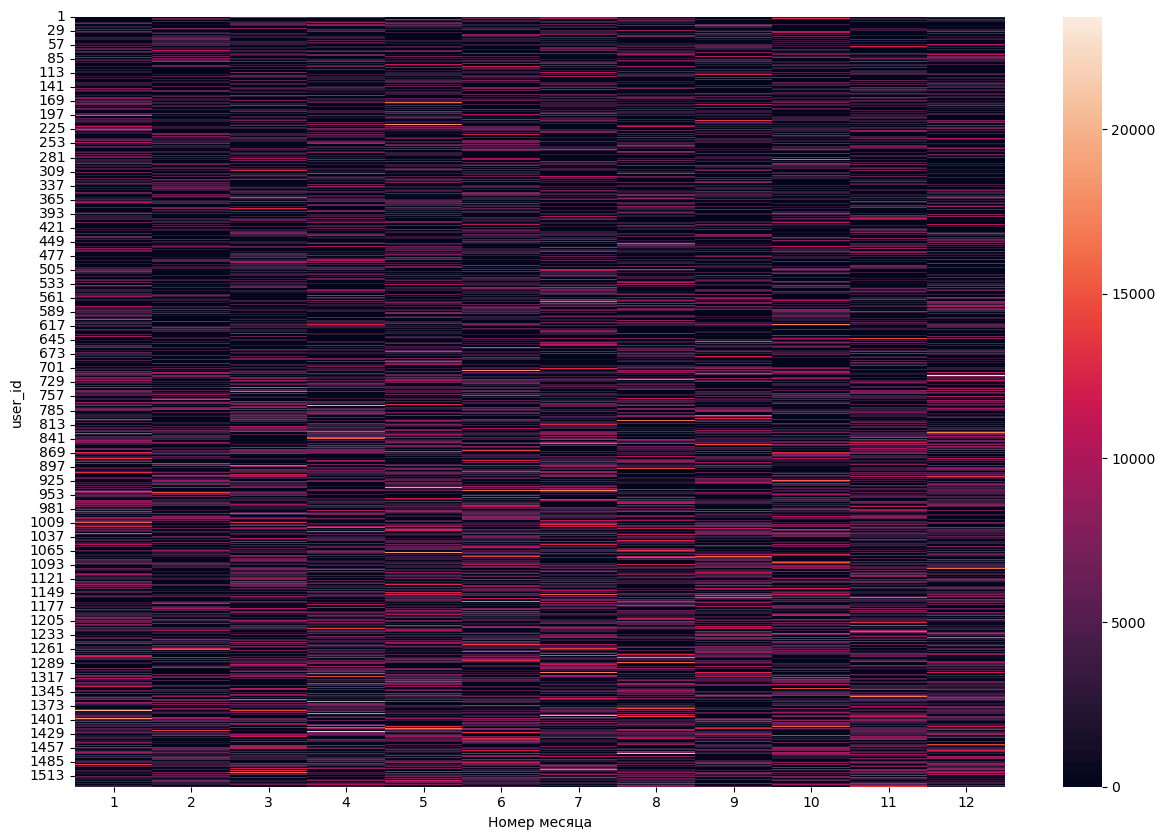

In [65]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(user_sum_distances)
ax.set_xlabel('Номер месяца');

Здесь попытка визуализировать сумарное растояние для каждого пользователя по месяцам. Я расчитывал увидеть явные отичия по сезонам.. летом более светлое (выше интесивность) зимой более темное (интесивность ниже). К сожалению, heatmap ничего такого не показал.. вывод который можно сделать по этой картинке такой , что, в целом, поезки не зависят от сезона.

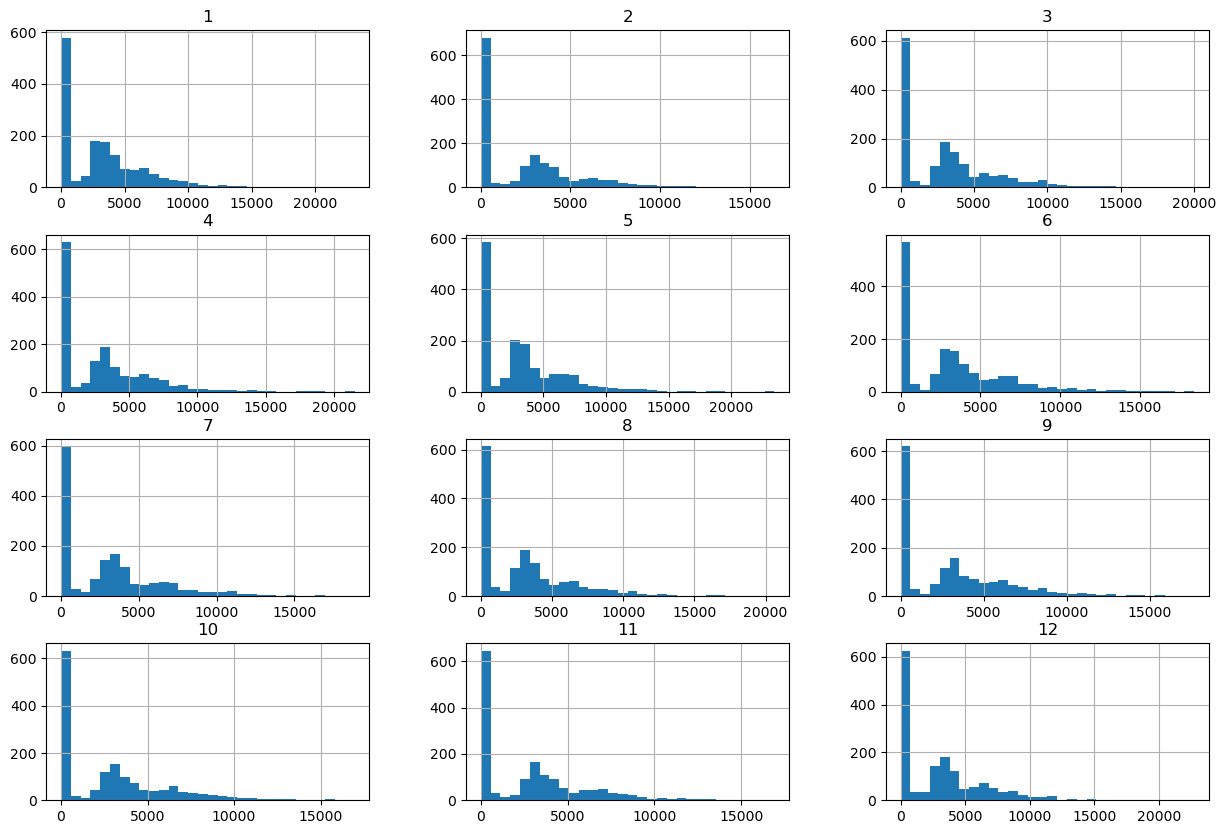

In [66]:
now_plt = user_sum_distances.hist(bins=30, figsize=(15, 10))

В каждом месяце сохраняется примерно 600 (за исключением сентября 500) пользователей, которые ни разу не воспользовались сервисом. Посмотрим на распределения без нулей.

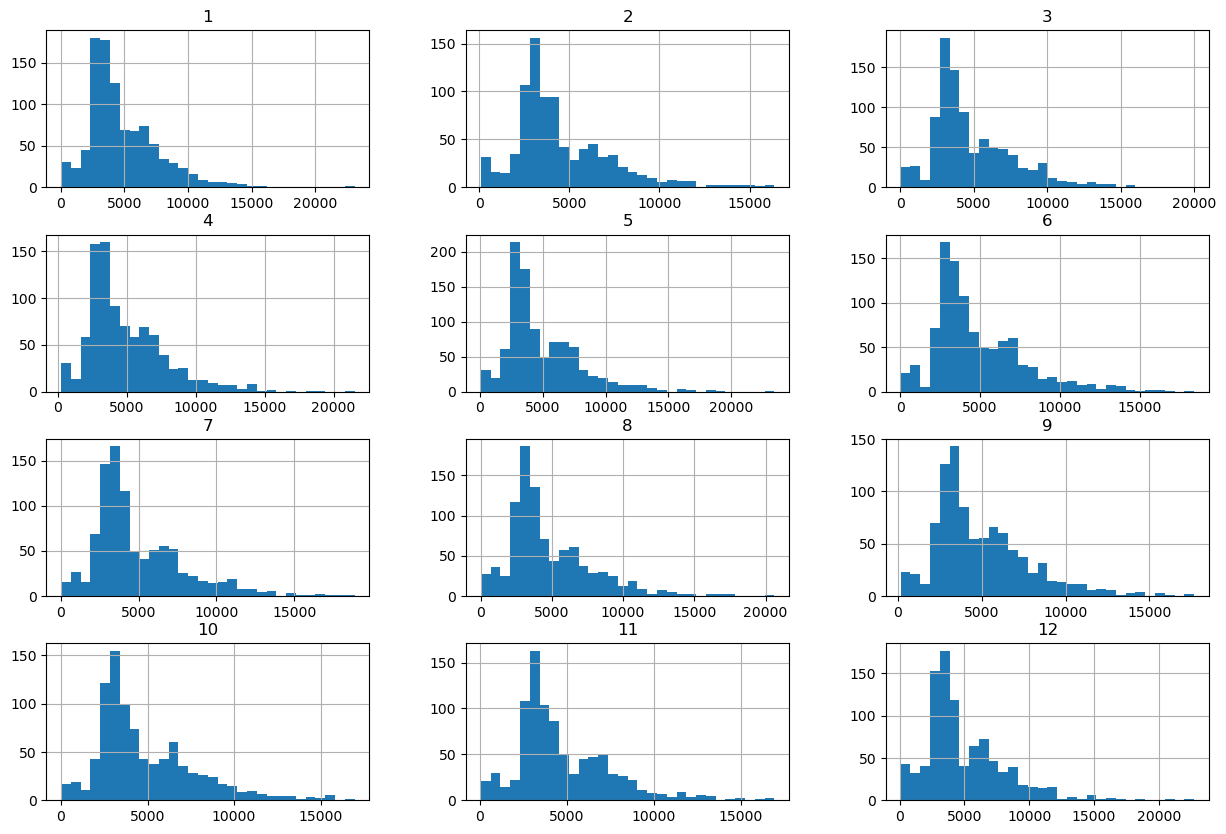

In [67]:
user_sum_distances[user_sum_distances != 0].hist(bins=30, figsize=(15, 10));

В среднем все месяцы похожи. Т.е. в основном пользователи ездят одинаково, но есть те кто ездят меньше и те кто больше. 

###### count 

In [68]:
user_rides_count = data.pivot_table(index='user_id', columns='month', values='distance', aggfunc='count')
user_rides_count.columns = range(1, 12+1)
user_rides_count.head()

,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1,2.0,NaN,NaN,1.0,NaN,NaN,NaN,2.0,NaN,2.0,3.0,2.0
2,NaN,NaN,3.0,2.0,NaN,1.0,2.0,1.0,NaN,1.0,NaN,1.0
3,1.0,2.0,NaN,1.0,3.0,NaN,3.0,NaN,1.0,NaN,NaN,1.0
4,NaN,2.0,NaN,NaN,NaN,2.0,3.0,1.0,NaN,4.0,2.0,NaN
5,1.0,1.0,3.0,1.0,2.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN


In [69]:
user_rides_count.isna().sum()

1     548
2     656
3     587
4     608
5     557
6     549
7     583
8     587
9     603
10    616
11    627
12    587
dtype: int64

In [70]:
user_rides_count = user_rides_count.fillna(0)

In [71]:
user_rides_count.isna().sum()

1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

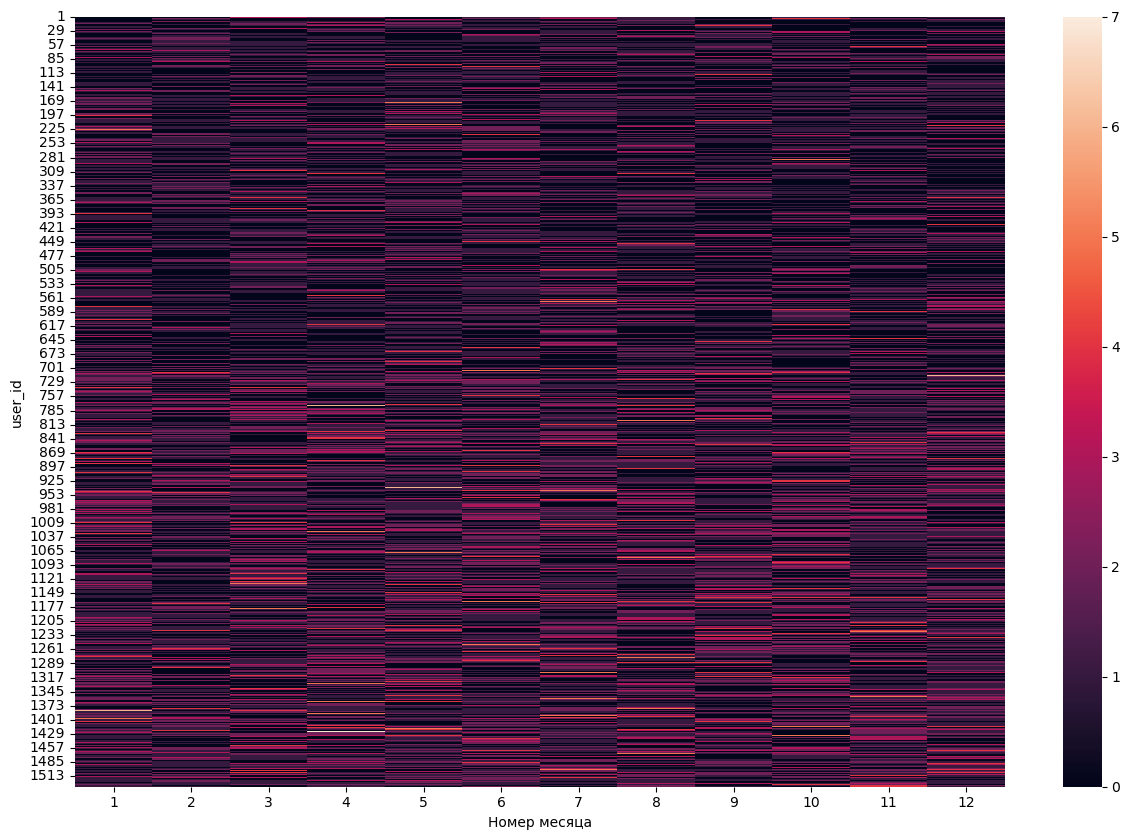

In [72]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(user_rides_count)
ax.set_xlabel('Номер месяца');

Тут то же самое, что для аналогичного рисунка выше, но для количества поездок.

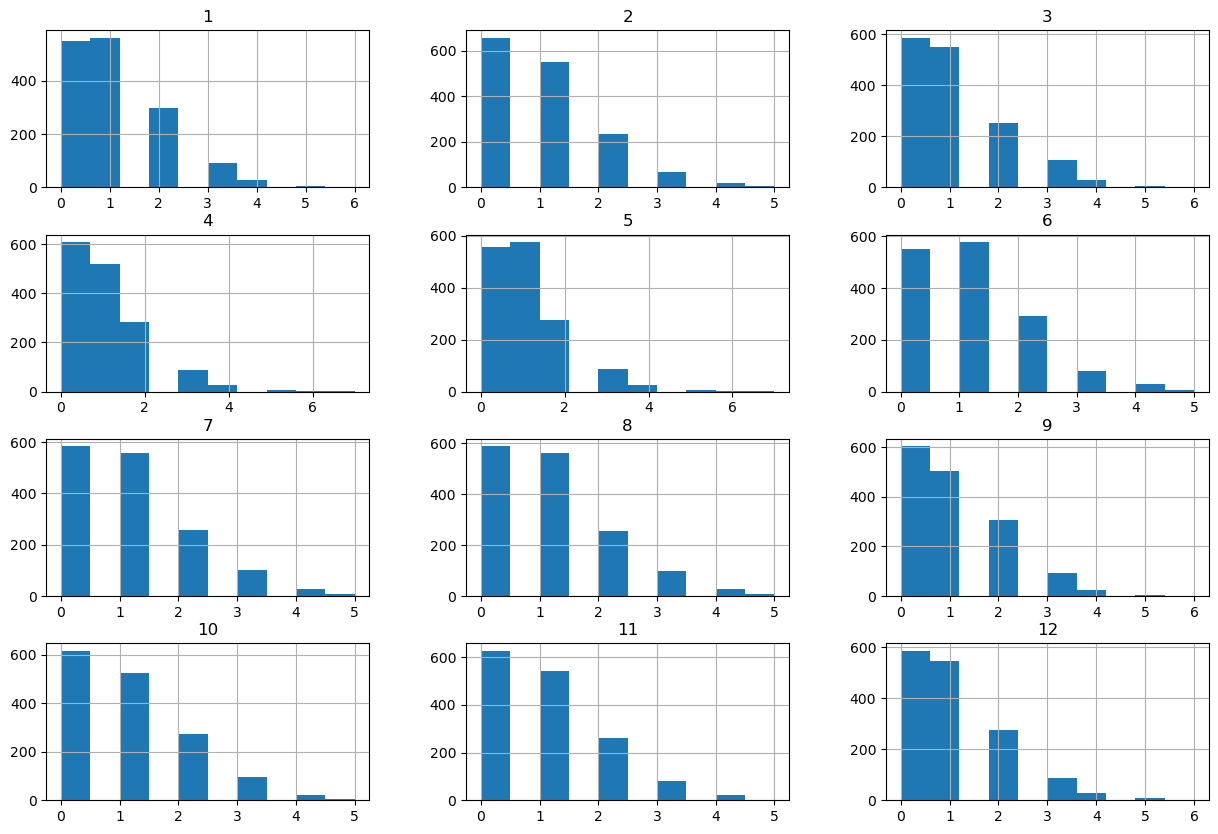

In [73]:
user_rides_count.hist(figsize=(15, 10));

В каждом месяце большая часть пользователей не пользуется сервисом.

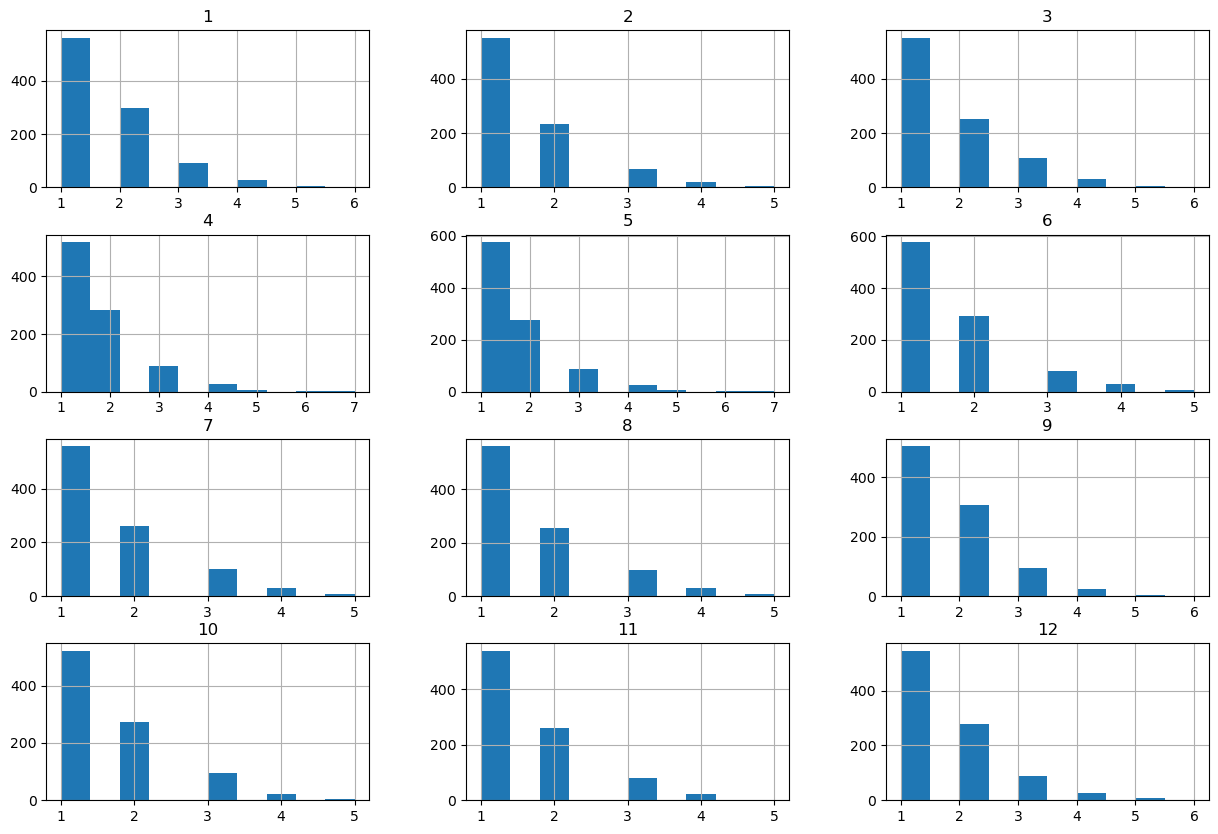

In [74]:
user_rides_count[user_rides_count != 0].hist(figsize=(15, 10));

Без учета тех, кто не пользуется сервисом, число использований в месяц уменьшается с ростом числа использованиий от 1, к 2 и.т.д

###### duration sum

In [75]:
user_sum_duration = data.pivot_table(index='user_id', columns='month', values='duration', aggfunc='sum')
user_sum_duration.columns = range(1, 12 + 1)
user_sum_duration.head()

,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1,41.416640,NaN,NaN,6.232113,NaN,NaN,NaN,44.776802,NaN,31.578017,53.397424,27.203912
2,NaN,NaN,60.959959,39.048633,NaN,13.851127,46.170157,6.914760,NaN,18.779128,NaN,11.920514
3,12.654443,37.568637,NaN,20.671364,61.404503,NaN,65.519784,NaN,22.390055,NaN,NaN,12.984728
4,NaN,48.150598,NaN,NaN,NaN,43.607518,55.249009,35.896929,NaN,77.992731,27.666796,NaN
5,12.395153,11.087710,55.666862,14.904990,31.299780,NaN,11.948739,17.046260,NaN,19.724438,NaN,NaN


In [76]:
user_sum_duration.isna().sum()

1     548
2     656
3     587
4     608
5     557
6     549
7     583
8     587
9     603
10    616
11    627
12    587
dtype: int64

In [77]:
user_sum_duration = user_sum_duration.fillna(0)

In [78]:
user_sum_duration.isna().sum()

1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

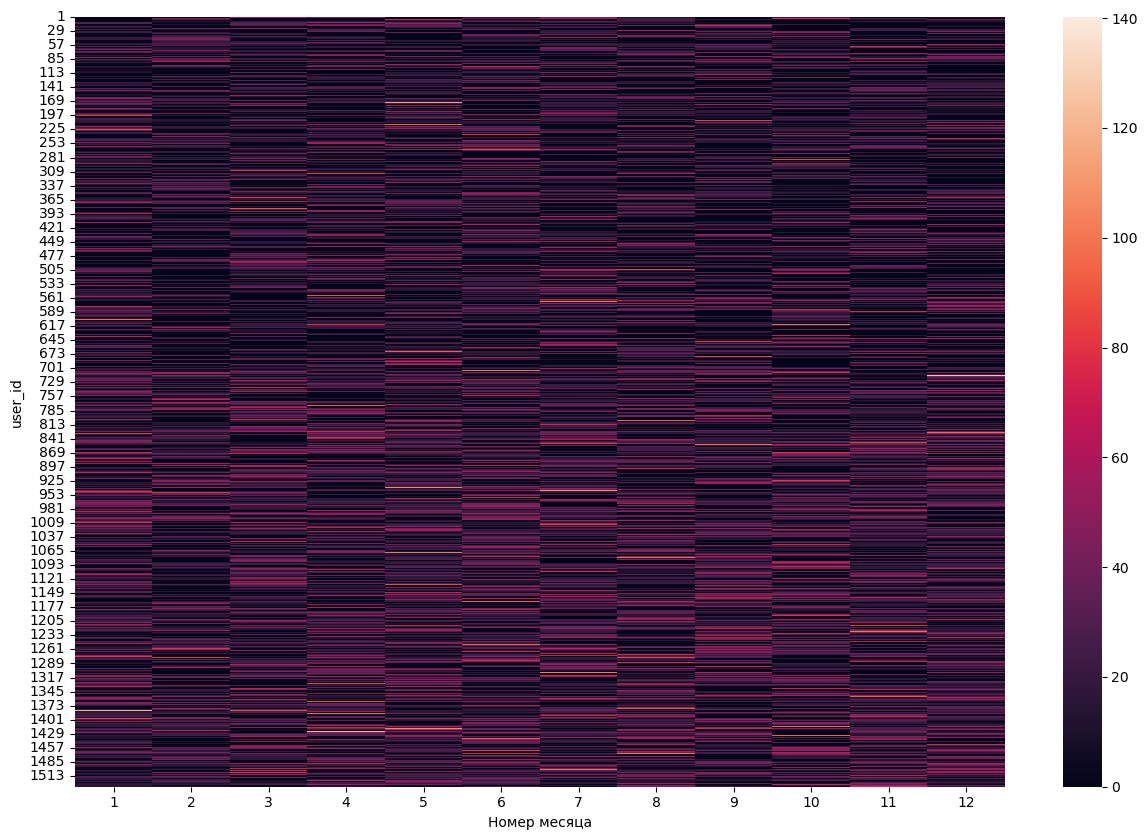

In [79]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(user_sum_duration)
ax.set_xlabel('Номер месяца');

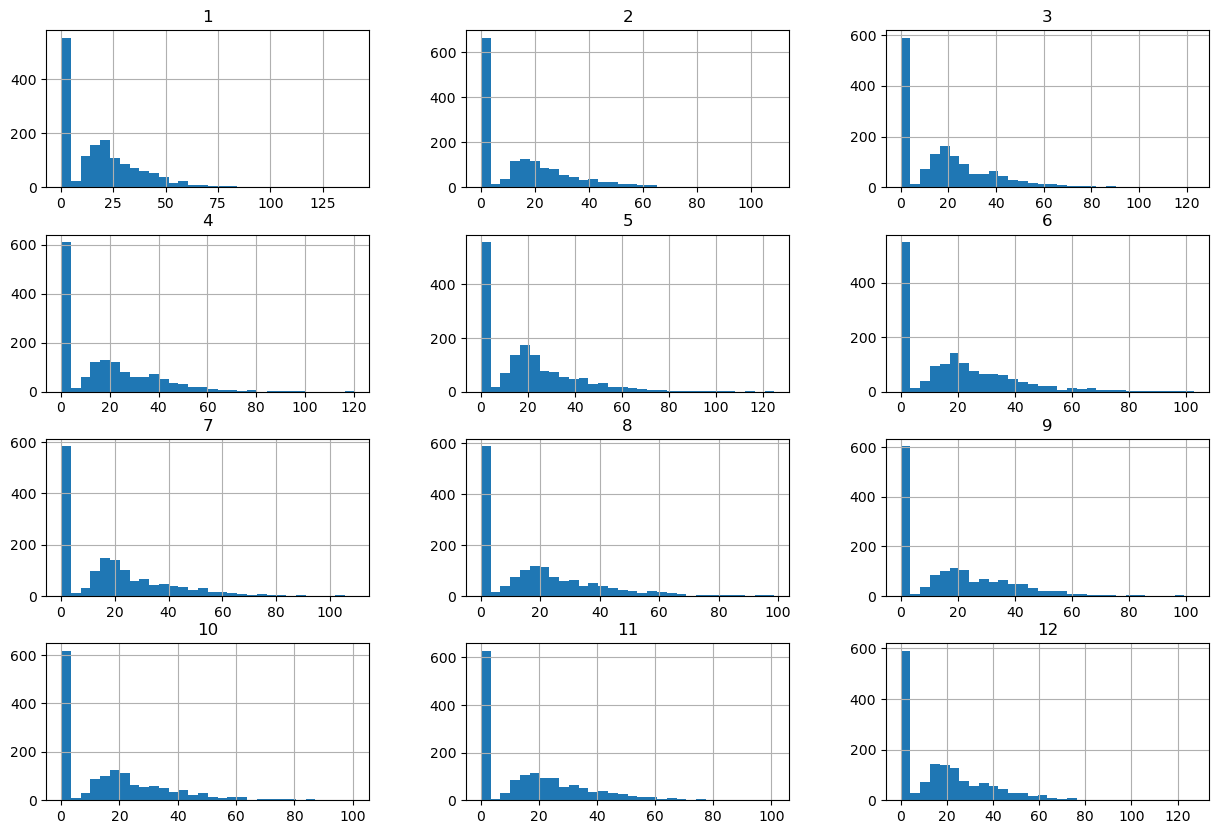

In [80]:
user_sum_duration.hist(bins=30, figsize=(15, 10));

Так как очень много пользователей не ездящих совсем, в каждом месяце есть максимум в 0.

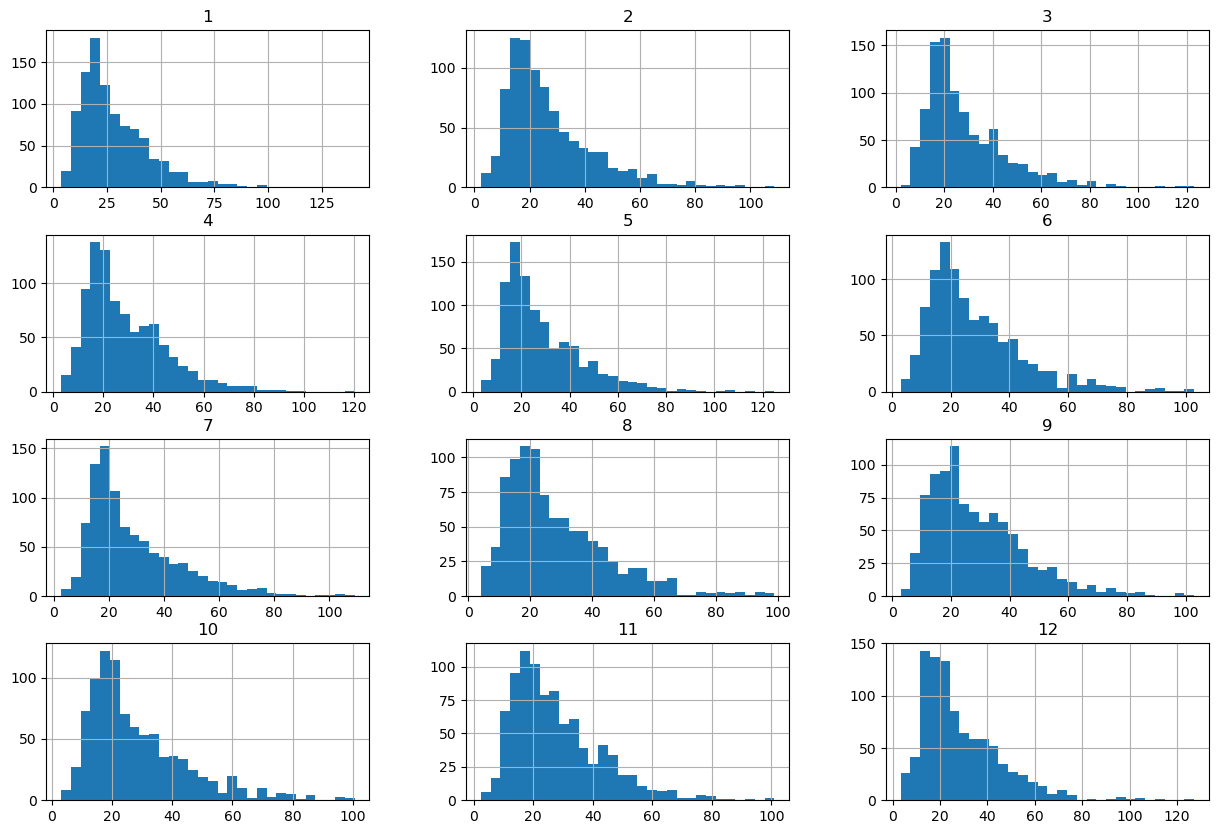

In [81]:
user_sum_duration[user_sum_duration != 0].hist(bins=30, figsize=(15, 10));

В каждом месяце распределение продолжительности близко к нормальному. У всех разные стандартные отклонения и у всех (кроме января) близкие значения среднего.

##### Добавьте столбец с помесячной выручкой, которую принёс каждый пользователь

In [82]:
def user_month_profit_func(row):
   return np.ceil(
                   row['subscription_fee'] + 
                   row['start_ride_price'] * row['count'] + 
                   row['minute_price'] * row['duration'])

In [83]:
data.duration.head()

0    25.599769
1    15.816871
2     6.232113
3    18.511000
4    26.265803
Name: duration, dtype: float64

In [84]:
data.duration.tail()

17968    19.822962
17969    21.409799
17970    18.435051
17971    16.674362
17972    15.893917
Name: duration, dtype: float64

In [85]:
data['duration'] = np.ceil(data['duration'])

In [86]:
data.duration.head()

0    26.0
1    16.0
2     7.0
3    19.0
4    27.0
Name: duration, dtype: float64

In [87]:
data.duration.tail()

17968    20.0
17969    22.0
17970    19.0
17971    17.0
17972    16.0
Name: duration, dtype: float64

In [88]:
user_month_profit = (data.groupby(['user_id', 
                                   'month', 
                                   'start_ride_price',
                                   'subscription_type',
                                   'subscription_fee',
                                   'minute_price'], 
                                  as_index=False)
                         .agg({'name':'count', 'duration':'sum'}))
user_month_profit = user_month_profit.rename(columns={'name':'count'})
user_month_profit.head()

,user_id,month,start_ride_price,subscription_type,subscription_fee,minute_price,count,duration
0,1,1,0,ultra,199,6,2,42.0
1,1,4,0,ultra,199,6,1,7.0
2,1,8,0,ultra,199,6,2,46.0
3,1,10,0,ultra,199,6,2,32.0
4,1,11,0,ultra,199,6,3,56.0


In [89]:
user_month_profit.tail()

,user_id,month,start_ride_price,subscription_type,subscription_fee,minute_price,count,duration
11295,1534,6,50,free,0,8,2,26.0
11296,1534,8,50,free,0,8,2,48.0
11297,1534,9,50,free,0,8,1,23.0
11298,1534,11,50,free,0,8,4,78.0
11299,1534,12,50,free,0,8,1,16.0


Добавим в таблицу столбец с месячной выручкой

In [90]:
user_month_profit['month_profit'] = user_month_profit.apply(user_month_profit_func, axis=1)

In [91]:
user_month_profit

,user_id,month,start_ride_price,subscription_type,subscription_fee,minute_price,count,duration,month_profit
0,1,1,0,ultra,199,6,2,42.0,451.0
1,1,4,0,ultra,199,6,1,7.0,241.0
2,1,8,0,ultra,199,6,2,46.0,475.0
3,1,10,0,ultra,199,6,2,32.0,391.0
4,1,11,0,ultra,199,6,3,56.0,535.0
...,...,...,...,...,...,...,...,...,...
11295,1534,6,50,free,0,8,2,26.0,308.0
11296,1534,8,50,free,0,8,2,48.0,484.0
11297,1534,9,50,free,0,8,1,23.0,234.0
11298,1534,11,50,free,0,8,4,78.0,824.0


In [92]:
user_month_profit = user_month_profit[['user_id', 'month', 'month_profit', 'subscription_type']]
user_month_profit

,user_id,month,month_profit,subscription_type
0,1,1,451.0,ultra
1,1,4,241.0,ultra
2,1,8,475.0,ultra
3,1,10,391.0,ultra
4,1,11,535.0,ultra
...,...,...,...,...
11295,1534,6,308.0,free
11296,1534,8,484.0,free
11297,1534,9,234.0,free
11298,1534,11,824.0,free


Построим гистограмму месячной выручки для всех пользователей.

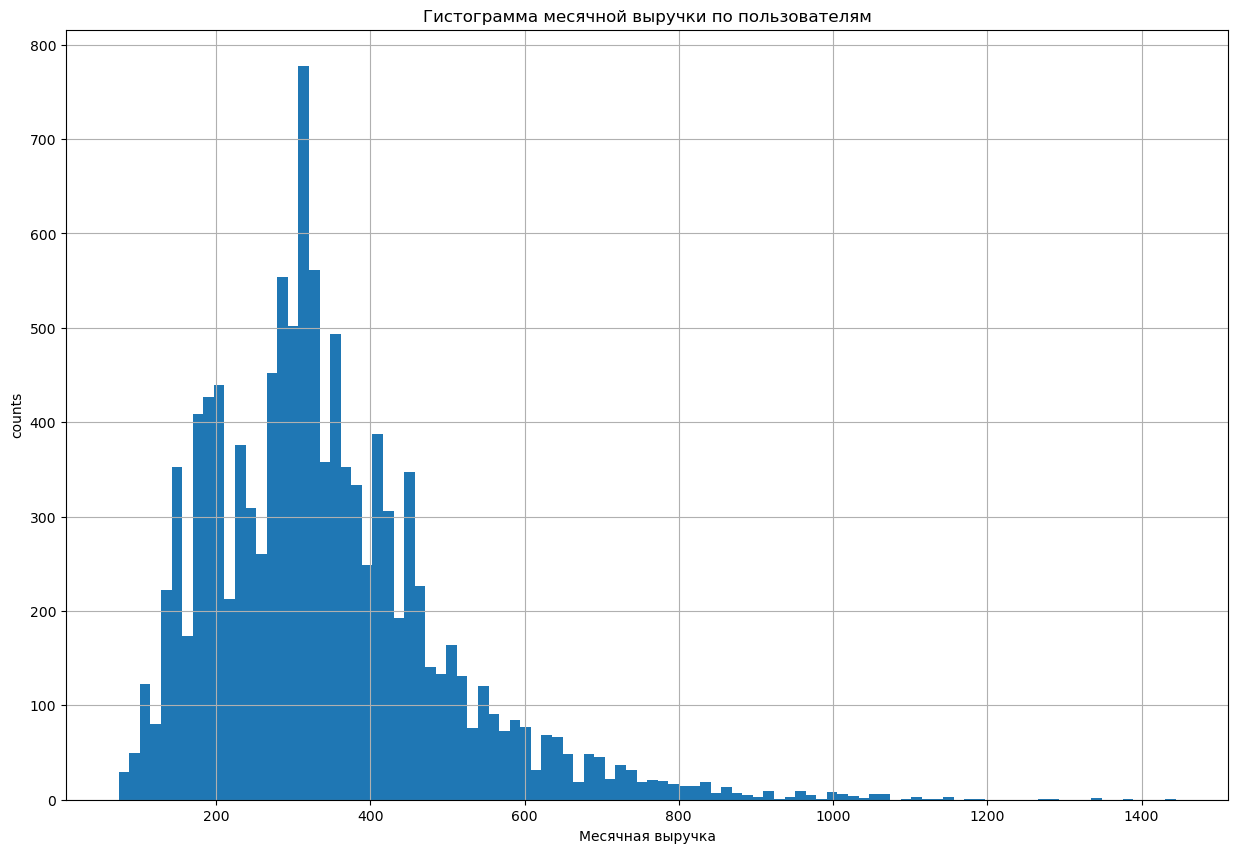

In [93]:
now_plt = user_month_profit.month_profit.hist(bins=100, figsize=(15, 10))
now_plt.set_title('Гистограмма месячной выручки по пользователям')
now_plt.set_xlabel('Месячная выручка')
now_plt.set_ylabel('counts');


In [94]:
user_month_profit.month_profit.describe()

count    11300.000000
mean       342.754956
std        153.317314
min         74.000000
25%        234.000000
50%        319.000000
75%        415.000000
max       1444.000000
Name: month_profit, dtype: float64

Разделим пользователей по подпискам. И построим гистограммы месячной выручки 

Разделим гистограмму для месячной выручки на гистограмму для пользователей с подпиской и без подписке, и построим их на одной канве.

Text(0.5, 0, 'Месячная выручка')

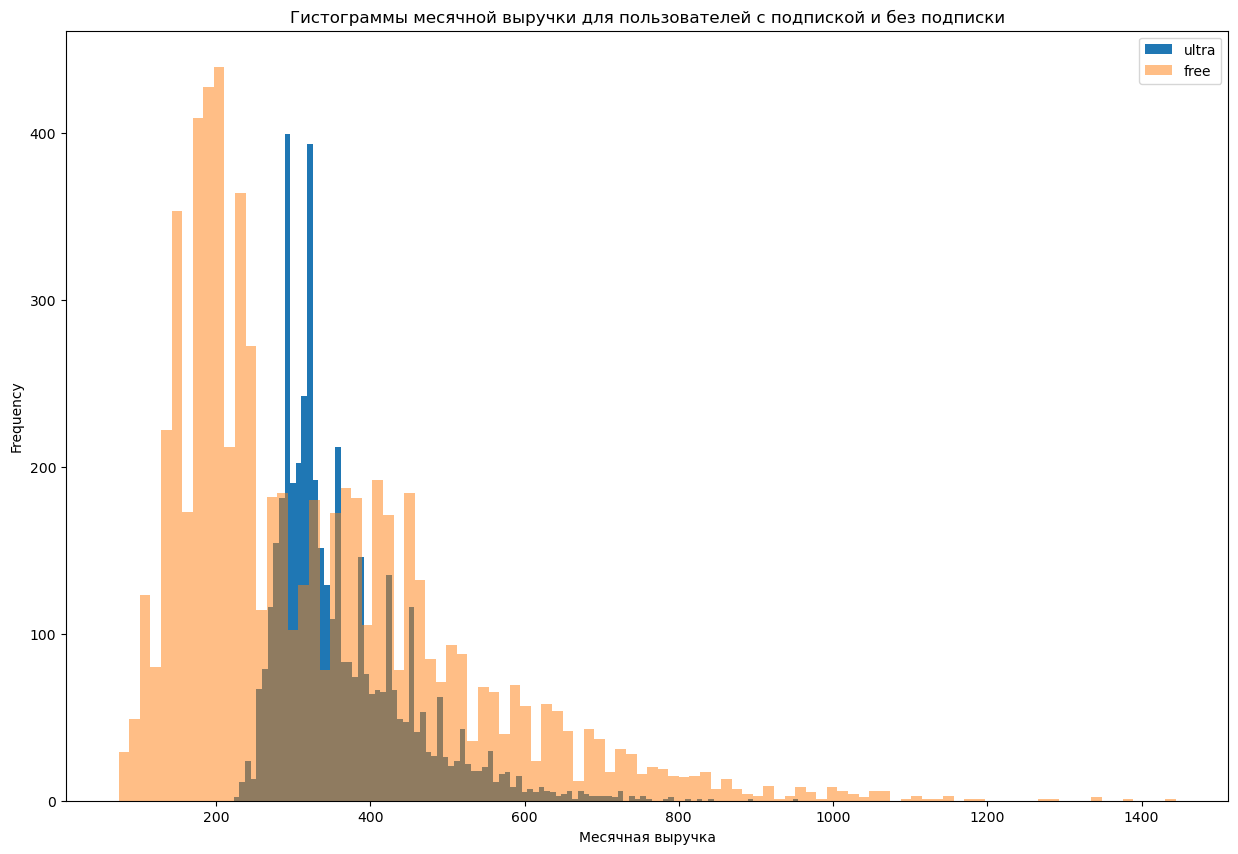

In [95]:
(user_month_profit[user_month_profit.subscription_type == 'ultra']
                                     .month_profit
                                     .plot(kind='hist', 
                                           bins=100, 
                                           figsize=(15, 10), 
                                           label='ultra',
                                           legend=True)
)

now_plt = (user_month_profit[user_month_profit.subscription_type == 'free']
                                     .month_profit
                                     .plot(kind='hist', 
                                           bins=100, 
                                           figsize=(15, 10), 
                                           label='free',
                                           legend=True,
                                           alpha=0.5)
)

now_plt.set_title('Гистограммы месячной выручки для пользователей с подпиской и без подписки')
now_plt.set_xlabel('Месячная выручка')

Распределение разделилось. Пик в 320 - характерен для пользователей с подпиской и для них все номально. Для пользователей без подписки есть основания полагать о наличии двух групп, тех кто тратят в среднем 200, и тех кто тратит в среднем примерно 400.

In [96]:
data = data.merge(user_month_profit, on=['user_id', 'month'])
data

,user_id,name,age,city,subscription_type_x,distance,duration,date,month,minute_price,start_ride_price,subscription_fee,month_profit,subscription_type_y
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199,451.0,ultra
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199,451.0,ultra
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199,241.0,ultra
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199,475.0,ultra
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199,475.0,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17968,1534,Альберт,25,Краснодар,free,3781.098080,20.0,2021-11-04,11,8,50,0,824.0,free
17969,1534,Альберт,25,Краснодар,free,2840.423057,22.0,2021-11-16,11,8,50,0,824.0,free
17970,1534,Альберт,25,Краснодар,free,3826.185507,19.0,2021-11-18,11,8,50,0,824.0,free
17971,1534,Альберт,25,Краснодар,free,2902.308661,17.0,2021-11-27,11,8,50,0,824.0,free


#### Шаг 6. Проверка гипотез

##### Тратят ли пользователи с подпиской больше времени на поездки? 

Для того что бы проверить эту гипотезу, сформулируем гипотезы:
1. **H0: mu_duration_ultra = mu_duration_free** (среднее время  поездок у пользователей с подпиской, равно среднему времени поездок у пользователей без подписки)
2. **H1: mu_duration_ultra > mu_duration_free** (среднее время поездок у пользоваетелей с подпиской, больше чем средненее время поездок у пользоателей без подписки) 

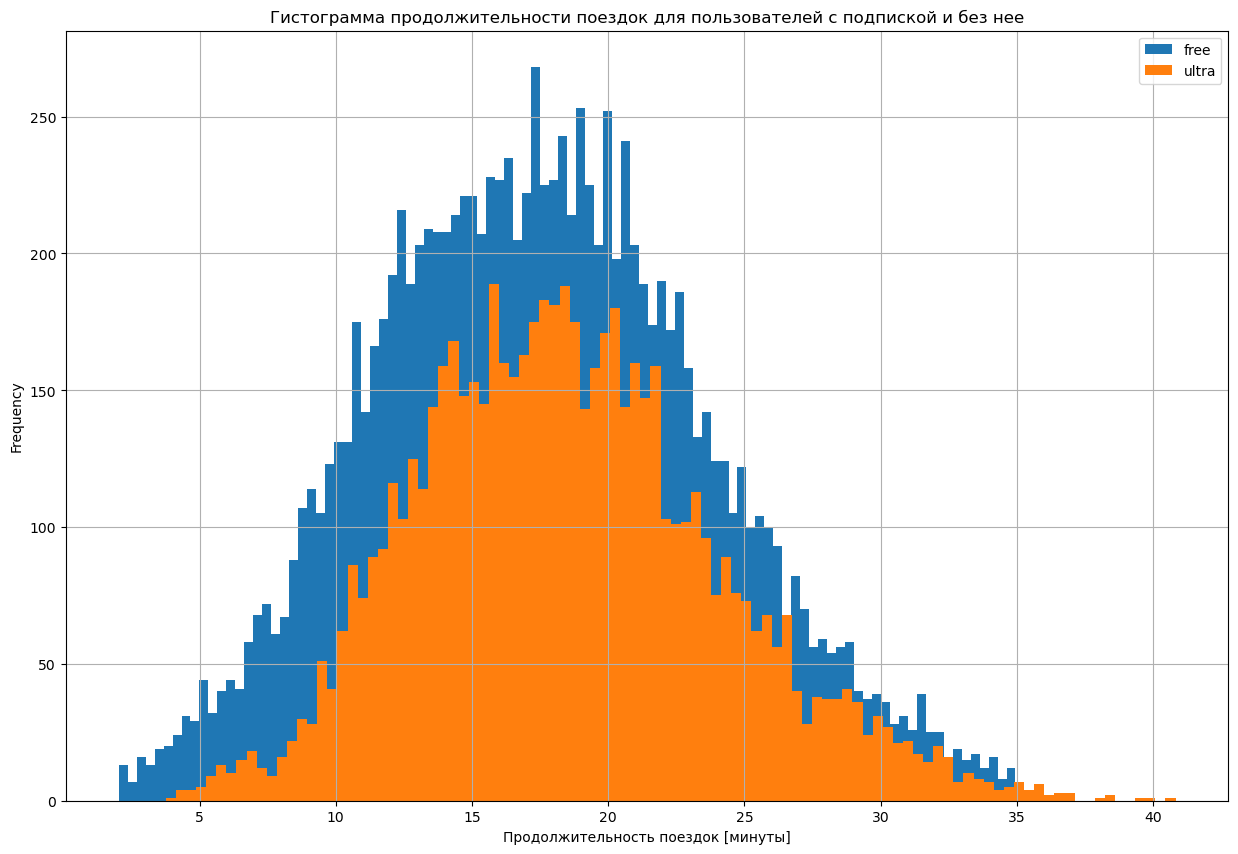

In [97]:
fig, ax = plt.subplots(figsize=(15, 10))
data_free.duration.plot(kind='hist', bins=100, figsize=(15, 10), label='free', legend=True, ax=ax)
data_ultra.duration.plot(kind='hist', bins=100, legend=True, label='ultra', ax=ax, grid=True)
ax.set_title('Гистограмма продолжительности поездок для пользователей с подпиской и без нее')
ax.set_xlabel('Продолжительность поездок [минуты]');

1. Совокопности пользователей с подпиской и пользователей без подписки - независимые между собой группы.
2. Выборочные средние рапределены нормально (рисунок выше это отражает)
3. На рисунке выше видно, что дисперсии могут отличаться. 

Проведем Т-тест с учетом этого факта **3**. 

In [98]:
result = st.ttest_ind(data_ultra.duration, data_free.duration, equal_var=False, alternative='greater')

Зададим уровень значимости **0,01**

In [99]:
alpha = 0.01

Проверим полученное pvalue

In [100]:
print('Среднее время поездок пользователей с подпиской: ', round(data_ultra.duration.mean(), 2))
print('Среднее время поездок пользователей без подписки: ', round(data_free.duration.mean(), 2))
print('pvalue is', result.pvalue)
if result.pvalue < alpha:
    print('Нулевая гипотеза не верна, пользователи с подпиской ездят дольше чем пользователи без подписки!')
else:
    print('Нулевая гипотеза верна, средние совпадают!')

Среднее время поездок пользователей с подпиской:  18.54
Среднее время поездок пользователей без подписки:  17.53
pvalue is 1.6162210195311063e-29
Нулевая гипотеза не верна, пользователи с подпиской ездят дольше чем пользователи без подписки!


С уровнем значимости **0,01**, получено, что пользователи с подпиской в среднем ездят дольше чем пользователи без подписки. 

##### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

In [101]:
optimal_distance = 3130

1. **H0: mu_distance_ultra = optimal_distance** (нулевая гипотеза: среднее растояние равно 3130 метров)
2. **H1: mu_distance_ultra > optimal_distance** (альтернатива: среднее растояние больше 3130 метров)

In [102]:
result = st.ttest_1samp(data_ultra.distance, optimal_distance, alternative='greater')

In [103]:
print('Среднее растояние, которое проезжают пользователи с подпиской:', 
       round(data_ultra.distance.mean(), 2),
       'метров')
print('pvalue is', result.pvalue)
if result.pvalue < alpha:
    print('Нулевая гипотеза не верна, пользователи с подпиской ездят больше оптимального растояния 3130 метров!')
else:
    print('Не поучилось отвергнуть нулевую гипотезу!')

Среднее растояние, которое проезжают пользователи с подпиской: 3115.45 метров
pvalue is 0.9195368847849785
Не поучилось отвергнуть нулевую гипотезу!


Вывод: С уровнем значимости **0,01** получено, что среднее растояние которое проезжают пользователи с подпиской не превышеат оптимальные 3130 метров.

##### Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

In [104]:
user_month_profit

,user_id,month,month_profit,subscription_type
0,1,1,451.0,ultra
1,1,4,241.0,ultra
2,1,8,475.0,ultra
3,1,10,391.0,ultra
4,1,11,535.0,ultra
...,...,...,...,...
11295,1534,6,308.0,free
11296,1534,8,484.0,free
11297,1534,9,234.0,free
11298,1534,11,824.0,free


Text(0.5, 0, 'Месячная выручка')

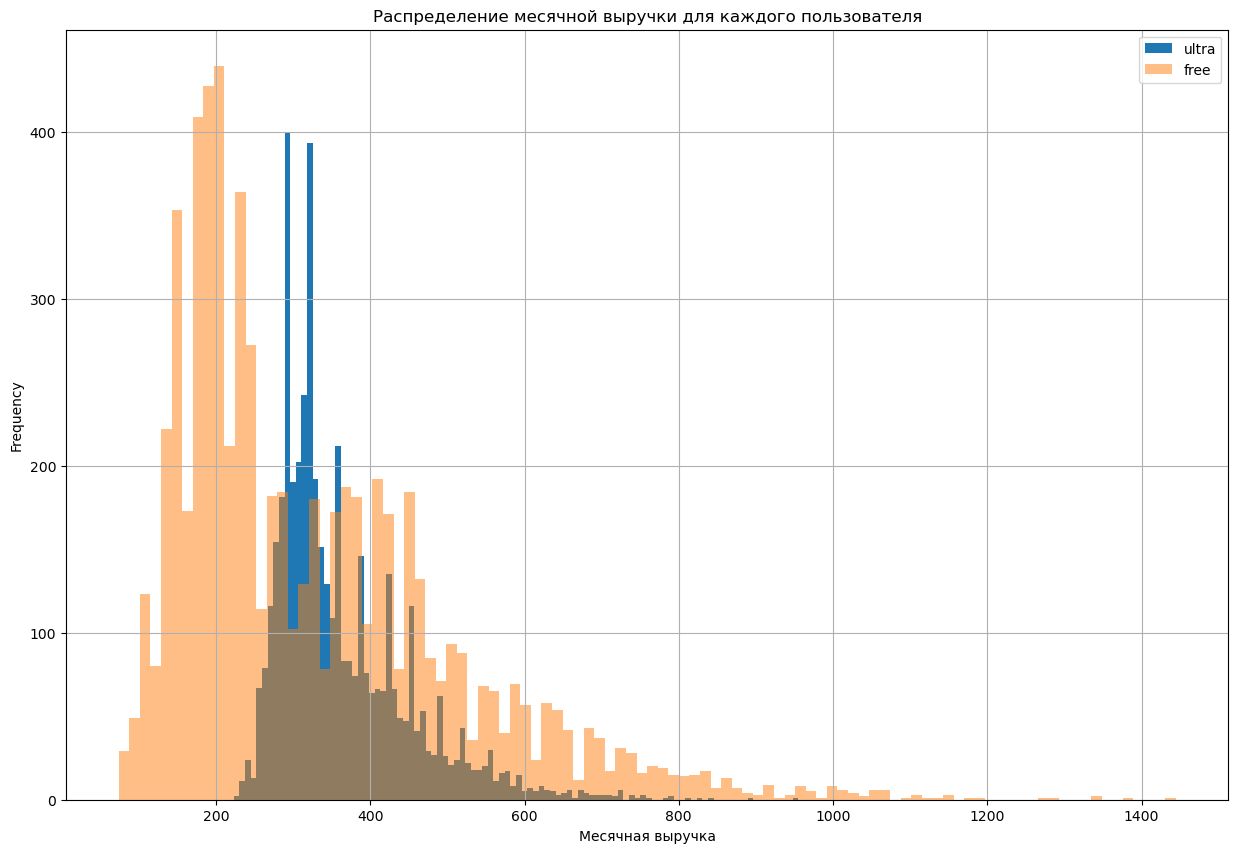

In [105]:
(user_month_profit[user_month_profit.subscription_type == 'ultra'].month_profit
                                    .plot(kind='hist', bins=100, legend=True, label='ultra', figsize=(15, 10),
                                          title='Распределение месячной выручки для каждого пользователя')
)

now_plt = (user_month_profit[user_month_profit.subscription_type == 'free'].month_profit
                                    .plot(kind='hist', bins=100, legend=True, label='free', alpha=0.5, grid=True)
)
now_plt.set_xlabel('Месячная выручка')

Дисперсии явно разные. Учтем это при впроведении Т-теста.
1. **H0: mu_ultra_month_profit = mu_free_month_profit** (Средняя месячная выручка от пользователей с подпиской, равна месячной выручке от пользователей без подписки).
2. **H1: mu_ultra_month_profit > mu_free_month_profit** (Средняя месячная выручка от пользователей с подпиской, больше месячной выручки от пользователей без подписки).

In [106]:
result = (st.ttest_ind(user_month_profit[user_month_profit.subscription_type == 'ultra'].month_profit,
                       user_month_profit[user_month_profit.subscription_type == 'free'].month_profit,
                       equal_var=False, 
                       alternative='greater')
         )

In [107]:
print('Средняя месячная выручка от пользователей с подпиской: ', 
       round(user_month_profit[user_month_profit.subscription_type == 'ultra'].month_profit.mean(), 2))
print('Средняя месячная выручка от пользователей без подписки: ', 
       round(user_month_profit[user_month_profit.subscription_type == 'free'].month_profit.mean(), 2))
print('pvalue is', result.pvalue)
if result.pvalue < alpha:
    print('Нулевая гипотеза не верна, пользователи с подпиской платят в месяц больше!')
else:
    print('Не получислось отвергнуть нулевую гипотезу!')

Средняя месячная выручка от пользователей с подпиской:  362.79
Средняя месячная выручка от пользователей без подписки:  329.33
pvalue is 2.4970242872858465e-38
Нулевая гипотеза не верна, пользователи с подпиской платят в месяц больше!


Вывод: С **0,01** уровнем значимости, получено, что в среднем пользователи с подпиской в месяц приносят больше денег, чем пользователи без подписки!

##### Доп. вопрос

*Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?*

Ответ: Нам понадобится Т-тест для зависимых парных выборок. **Первая выборка** будет - распределение числа обращений (какое конкретно, не важно.. т.е. либо по периоду: число обращений в один день, либо как-то иначе) до обновления сервиса, **вторая выборка** - распределение числа обращений (построенное абсолютно по той же логике, что и первое) после обновления сорвиса. Обязательно проследить, что порядок в котором сделаны изерения в первом случае, то же что во втором случае, а также размеры обоих выборок должны в точности совпадать. Далее провести Т-тест из библотеки python:  **scipy.stats.ttest_rel(array1, array2)**.  

#### Шаг 7. Распределения

##### Промокоды

Задача: *Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соотвествующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 %пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.*

Нужно использовать биномиальное распределение, которое хорошо опишет интересуемый нас эксперимент: каждый отдельный пользователь с пробной подпиской - это экспермент с двумя исходами: либо продлил, либо - нет.. Вероятность для каждого пользователя одна и таже p = 0,1.  

Выберем для начала количесво промокодов - 1000 т.е 100 * 10.

In [108]:
1. - st.binom.cdf(100, 1000, 0.1)

0.4734009187048347

Получается только 47% промокодов из 1000 будут успешны, а это меньше нашей цели в 0,95!
Подберем такое n, что вероятность получить 100 и более подписок будет сотавлять 0,95:

In [109]:
target = 0.95
prob = 0.
p = 0.1
n = 99

while prob < target:
    prob = 1. - st.binom.cdf(100, n, p)
    n += 1

print('prob=', prob, ', target n = ', n)

prob= 0.9504520478979693 , target n =  1173


Ответ: Для того чтобы привлечь минимум 100 пользователей с вероятностью 0,95, нужно разослать **1173** промокода.

Результат в принципе верный, но промокодов понадобится чуть меньше. 

При передаче целевого значения n в метод binom.cdf() необходимо вычитать из него единицу. То есть передавать не 100, а 99.

In [110]:
target = 0.05
prob = 1.
p = 0.1
n = 99

while round(prob, 2) > target:
    prob = st.binom.cdf(100, n, p)
    n += 1

print('prob=', prob, ', target n = ', n)

prob= 0.05458584628323271 , target n =  1168


##### push уведомления

*Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.*

*Эта ситуация тоже описывается биномиальным распределением. Но считать каждое отдельное значение достаточно долго. Вы можете воспользоваться нормальной аппроксимацией биномиального распределения и cdf() для быстрой оценки.* Так и сделаем.

Сначала построим примерный график:

In [111]:
# зададим функцию, которая выдаёт <num> чисел,
# равномерно распределённых от <start> до <stop>
# (понадобится для визуализации нормального распределения)
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result

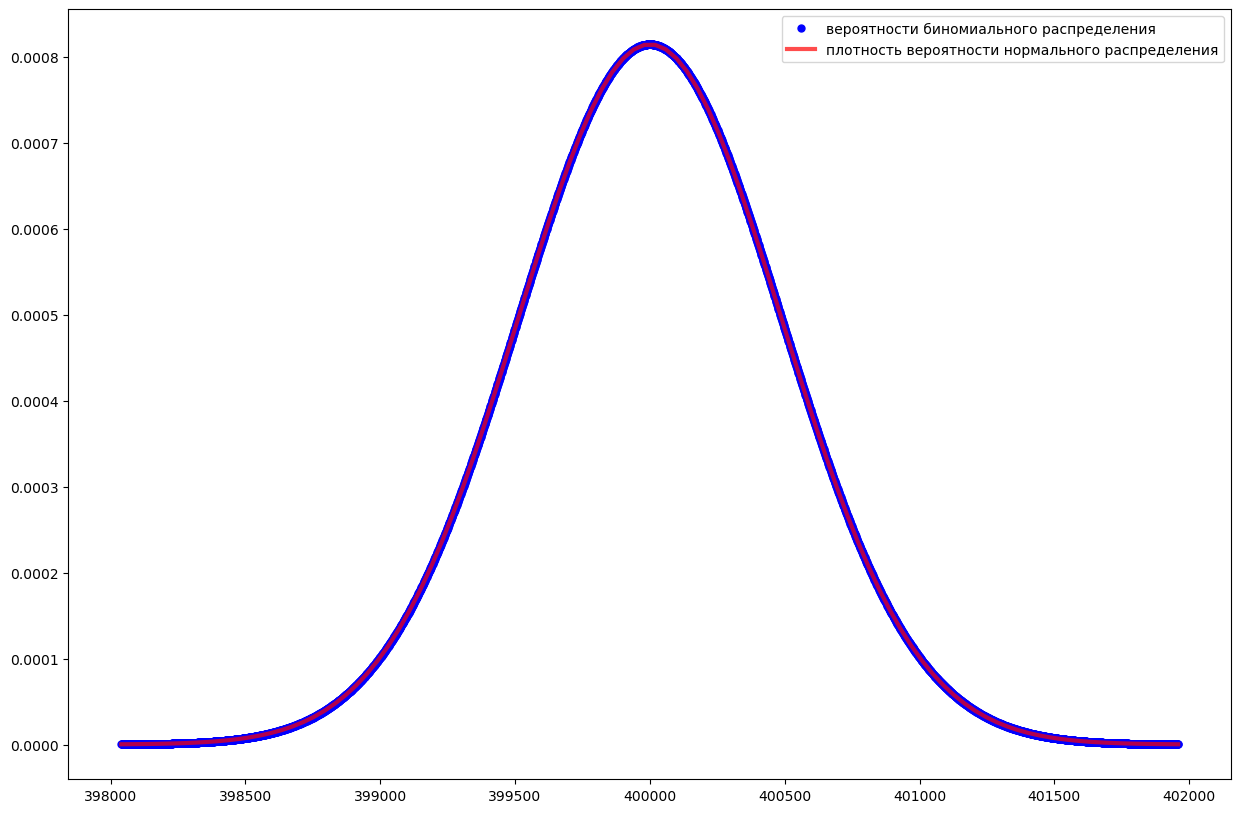

In [112]:
p = 0.4
n = 1 * 10**6

EX = n * p
varX = n * p *(1. - p)

distr = st.norm(EX, np.sqrt(varX))

# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 4 ст.отклонения бином.распределения
# до n*p плюс 4 ст.отклонения бином.распределения
# (там, где вероятности значений почти не равны нулю)
left = int(n * p - 4 * np.sqrt(n * p * (1 - p)))
right = int(n * p + 4 * np.sqrt(n * p * (1 - p)))

# зададим набор значений биномиальной величины на выбранном промежутке:
# все неотрицательные целые числа от left до right
x = list(range(max(0, left), right))

# рисуем график биномиального распределения
fig, ax = plt.subplots(figsize=(15, 10))

# используем синие о-образные маркеры и размер маркера 5
ax.plot(x, st.binom.pmf(x, n, p), 'bo', ms=5, 
	      label='вероятности биномиального распределения')

# зададим параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = np.sqrt(n * p * (1 - p))
 
# рисуем график нормального распределения:
# получим список из 100 чисел от left до right
x = linspace(left, right, 100)
# используем красную линию ширины 3 и прозрачности 0.3
ax.plot(x, st.norm.pdf(x, mu, sigma), 'r-', lw=3, alpha=0.7, label='плотность вероятности нормального распределения')
 

# настраиваем оптимальное расположение легенды и выводим график
ax.legend(loc='best')
plt.show()


Найдем вероятность того, что уведомление откроют не более 399,5 тысяч пользователей. Будем считать cdf для левого хвоста, т.к. "не более":

In [113]:
target = 399.5 * 10**3
print('Искомая вероятность:', distr.cdf(target))

Искомая вероятность: 0.15371708296369768


Ответ: Вероятность того, что из 1 милиона уведомлений, откроют не более 399,5 тысяч составляет примерно **15%**. Следвательно, более 399,5 тысяч откроют с вероятностью 85%.

#### Вывод

- В результате предобработки было проведено следующее:
    - данные в `usres`, столбце `date` приведены к типу *datetime*
    - в `users` добавлен столбец `month` с номером месяца
    - в `users` удалено **31** дублирующих информацию строки
    - проверено, что таблицы `users` и `rides` содержат `user_id` одних и тех же пользователей
    - в `rides` обнаружены аномально короткие поезки в **0.5** минуты, с несоотвесвующим растоянием. Всего **0.5%** аномальных строк, все из которых были удалены.
    
- В результате исследовательского анализа данных было получено:
    - Всего приложение используют в 8 городах. Больше всего клиентов в Пятигорске, меньше всего в Москве.
    - **54%** пользователей сервиса без подписки (**free**) и **46%** - с подпиской (**ultra**)
    - Распределение возраста пользователей - близко к нормальному, со средним **25** и стандартным отклонением **5**. Минимальный возрас пользователя **12** лет, максимальный **43**
    - Распределение растояния, которое проезжают пользователи имеет 2 пика. Это может говорить о том, что имеют место быть типы поездок: на малые расстояния и на большие. 
    - Распределение продолжительности поездок нормальное, со средним в **18** минут и sts **6** минут.

- Посчитана месячная выруска для каждого пользователя. Пользователи с подпиской, приносят в среднем **320**. Для пользователей без подписки есть основания полагать о наличии двух групп, тех кто приносит в среднем **200**, и **400** соотвественно.
- С уровнем значимости **0,01**, получено, что пользователи с подпиской в среднем ездят дольше чем пользователи без подписки. 
    - Среднее время поездок пользователей с подпиской:  **18.54** минут. 
    - Среднее время поездок пользователей без подписки:  **17.53** минут
- С уровнем значимости **0,01** получено, что среднее растояние которое проезжают пользователи с подпиской не превышеат оптимальные **3130** метров.
    - Среднее растояние, которое проезжают пользователи с подпиской: **3115.45** метров
- С **0,01** уровнем значимости, получено, что в среднем пользователи с подпиской в месяц приносят больше денег, чем пользователи без подписки!
    - Средняя месячная выручка от пользователей с подпиской:  **362.79**
    - Средняя месячная выручка от пользователей без подписки:  **329.33**
-  **1168** это минимальное количество промокодов, которое нужно разослать, чтобы вероятность не выполнить план была примерно **5 %**, при условии что план это **100** новых пользователей продливших подписку, а вероятность успеха для кажого **10%**.